In [1]:
import os, sys, argparse
from upsetplot import from_memberships
from upsetplot import plot
%matplotlib inline 
from matplotlib import pyplot
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
from itertools import combinations
from comb import parse_maf, my_combs_frozenset, my_combs_all, my_combs, my_combos
from inter import intersections
from howmany import how_many_tumor_cgc
from contents import set_contents
from df import baileydf, cgcdf, pancandf
from tabulate import tabulate

original = os.getcwd()


In [2]:
possible_callers = ('muse', 'mutect', 'somaticsniper', 'varscan')

possible_cancers = ('ACC', 'BLCA','BRCA','CESC','CHOL','COAD','DLBC','ESCA','GBM','HNSC', 
					'KICH','KIRC','KIRP','LAML','LGG','LIHC','LUAD','LUSC','MESO', 'OV','PAAD',
                    'PCPG','PRAD','READ','SARC','SKCM','STAD','TGCT','THCA','THYM','UCEC','UCS','UVM')
callers = ['mutect','varscan']
additional_callers = ['somaticsniper','muse']
keys = my_combs_frozenset(possible_callers, len(possible_callers))

impacts = set(('MODERATE', 'HIGH'))
filt = set(('PASS',))
dfcgc = cgcdf(possible_cancers, possible_callers, keys, original, impacts, filt)

In [37]:


def individual_analysis(original, cancer, possible_callers, tabu):
    os.chdir(original)
    cgc = pd.read_csv('Cancer_Gene_Census_all_Jun-11-2019.csv', usecols = (0,9))
    os.chdir(cancer)
    mafs = os.listdir()

    maf_fps = {}
    for caller in possible_callers:
        for maf in mafs:
            if caller in maf: # str in the filepath
                maf_fps[caller] = maf

    all_variants = {}
    
    for caller in maf_fps:
        all_variants[caller] = parse_maf(maf_fps[caller])
    arg = []
    for i in range(len(possible_callers)):
        arg.append(all_variants[possible_callers[i]])   
    
    
    patients = set(list(arg[0].keys()))
    for i in range(len(arg)):
        patients = patients & set(list(arg[i].keys()))

    patients = list(patients)
    
    allrealdiff = []
    alltotaldiff = []
    allreal = []
    
    total = np.zeros(4)

    for k in range(len(patients)):
        df = pd.DataFrame(0, index=keys, columns=[cancer,])
        data = dict([(key, []) for key in keys])
        sets = []
        for j in range(len(arg)):
            sets.append(arg[j][patients[k]])
        
        inters = intersections(sets)
    
        for i in range(len(inters)):
            data[keys[i]].extend(list(inters[i]))
        
        df.loc[:,cancer] = how_many_tumor_cgc(data, cgc, filt, impacts, keys)
    
        t = table(callers, additional_callers, cancer, 2, impacts, filt, keys, bcp = df, individual = True, tab = False)        
        
        totaltable = table(callers, additional_callers, cancer, 2, impacts, filt, keys, bcp = dfcgc, individual = False, tab = False)
        indexorder = list(totaltable.index)
        
        t = t.reindex(indexorder)
        
        total = total + np.array(t['real'])
    
        if all(np.isfinite(t['real % diff'])):
            allrealdiff.append(np.array(t['real % diff']))
        if all(np.isfinite(t['total % diff'])):
            alltotaldiff.append(np.array(t['total % diff']))
        if all(np.isfinite(t['% of all real'])):
            allreal.append(np.array(t['% of all real']))
    allvar = []
    averages = pd.DataFrame(0, index=t.index, columns=('mean real', 'real std', 'mean total', 'total std', 'mean all real', 'all real std'))
    averages.loc[:,'mean real'] = np.mean(np.array(allrealdiff), axis = 0)
    for i in range(len(np.array(allrealdiff))):
        allvar.append(np.array(allrealdiff)[i][0])
    
    averages.loc[:,'mean total'] = np.mean(np.array(alltotaldiff), axis = 0)
    averages.loc[:,'mean all real'] = np.mean(np.array(allreal), axis = 0)
    averages.loc[:,'real std'] = np.std(np.array(allrealdiff), axis = 0)
    averages.loc[:,'total std'] = np.std(np.array(alltotaldiff), axis = 0)
    averages.loc[:,'all real std'] = np.std(np.array(allreal), axis = 0)
    #print(averages)
    if tabu == True:
        print(cancer)
        print(tabulate(averages, headers=['variant callers', 'mean real %', 'real % std', 'mean total %', 'total % std', 'mean all real %', 'all real % std'], tablefmt='psql',floatfmt=(".0f",".3f",".3f", ".3f",".3f",".3f", ".3f")))
    return averages, np.array(allrealdiff)

ave, real = individual_analysis(original, 'BRCA', possible_callers, tabu = True)




/Users/kathrynleung/bigdatax/somatic_mafs/table.py:70: RuntimeWarning: invalid value encountered in true_divide
  fractions = 100*(tops/realsum)
/Users/kathrynleung/bigdatax/somatic_mafs/table.py:77: RuntimeWarning: invalid value encountered in long_scalars
  rpercent.append(100*((sums['real'][i] - sums['real'][0]) / sums['real'][0]))
/Users/kathrynleung/bigdatax/somatic_mafs/table.py:83: RuntimeWarning: invalid value encountered in long_scalars
  tpercent.append(100*((sums['total'][i] - sums['total'][0]) / sums['total'][0]))
/Users/kathrynleung/bigdatax/somatic_mafs/table.py:77: RuntimeWarning: divide by zero encountered in long_scalars
  rpercent.append(100*((sums['real'][i] - sums['real'][0]) / sums['real'][0]))
/Users/kathrynleung/bigdatax/somatic_mafs/table.py:83: RuntimeWarning: divide by zero encountered in long_scalars
  tpercent.append(100*((sums['total'][i] - sums['total'][0]) / sums['total'][0]))


BRCA
+------------------------------------------------+---------------+--------------+----------------+---------------+-------------------+------------------+
| variant callers                                |   mean real % |   real % std |   mean total % |   total % std |   mean all real % |   all real % std |
|------------------------------------------------+---------------+--------------+----------------+---------------+-------------------+------------------|
| ('mutect', 'varscan', 'somaticsniper', 'muse') |        22.611 |       42.744 |          4.172 |        14.937 |           100.000 |            0.000 |
| ('mutect', 'varscan', 'muse')                  |        19.733 |       38.589 |          2.531 |        10.657 |            98.247 |            7.188 |
| ('mutect', 'varscan', 'somaticsniper')         |        12.534 |       31.516 |          1.771 |         8.209 |            93.485 |           14.116 |
| ('mutect', 'varscan')                          |         0.000 |     

In [13]:
# extrapolates size from cost, assuming equal cost and equal size for each patient, assumes num variants and size are linear
# could rewrite this function to take input size as an 
def cost(original, cancer, possible_callers, size, callers, additional_callers):
    df = pd.DataFrame(0, index=possible_callers, columns=['coefficient', 'constant'])
    df['coefficient'] = [5,3,9,1]
    df['constant'] = [2,10,4,2]
    constants = 0
    coefficients = 0
    for i in range(len(callers)):
        coefficients += df.loc[callers[i]]['coefficient']
        constants +=  df.loc[callers[i]]['constant']
        
    cost = coefficients*size +constants # size of each patient, extrapolated from cost
    averages = individual_analysis(original, cancer, possible_callers, tabu = False) # average patient stats
       
    costs = np.zeros(len(averages.index))

    for i in range(len(averages.index)):
        coefficient = 0
        constant = 0
        for caller in averages.index[i]:
            coefficient += df.loc[caller]['coefficient']
            constant +=  df.loc[caller]['constant']
        costs[i] = (coefficient * size + constant) 
    averages['cost'] = costs
    print(cancer)
    print(tabulate(averages, headers=['variant callers', 'mean real %', 'real % std', 'mean total %', 'total % std', 'mean all real %', 'all real % std', 'cost'], tablefmt='psql',floatfmt=(".0f",".3f",".3f", ".3f",".3f",".3f", ".3f", '.3f')))
    return averages

cost_table = cost(original, 'ACC', possible_callers, 100, ['mutect', 'varscan'], ['somaticsniper', 'muse'])


/Users/kathrynleung/bigdatax/somatic_mafs/table.py:70: RuntimeWarning: invalid value encountered in true_divide
  fractions = 100*(tops/realsum)
/Users/kathrynleung/bigdatax/somatic_mafs/table.py:77: RuntimeWarning: invalid value encountered in long_scalars
  rpercent.append(100*((sums['real'][i] - sums['real'][0]) / sums['real'][0]))
/Users/kathrynleung/bigdatax/somatic_mafs/table.py:83: RuntimeWarning: invalid value encountered in long_scalars
  tpercent.append(100*((sums['total'][i] - sums['total'][0]) / sums['total'][0]))
/Users/kathrynleung/bigdatax/somatic_mafs/table.py:77: RuntimeWarning: divide by zero encountered in long_scalars
  rpercent.append(100*((sums['real'][i] - sums['real'][0]) / sums['real'][0]))


ACC
+------------------------------------------------+---------------+--------------+----------------+---------------+-------------------+------------------+----------+
| variant callers                                |   mean real % |   real % std |   mean total % |   total % std |   mean all real % |   all real % std |     cost |
|------------------------------------------------+---------------+--------------+----------------+---------------+-------------------+------------------+----------|
| ('mutect', 'varscan', 'somaticsniper', 'muse') |        29.834 |       45.400 |          4.742 |        16.704 |           100.000 |            0.000 | 1818.000 |
| ('mutect', 'varscan', 'somaticsniper')         |        18.238 |       34.076 |          4.274 |        16.489 |            92.830 |           14.063 | 1316.000 |
| ('mutect', 'varscan', 'muse')                  |        22.129 |       36.300 |          0.979 |         4.543 |            94.407 |           11.276 |  914.000 |
| ('mu

/Users/kathrynleung/bigdatax/somatic_mafs/table.py:70: RuntimeWarning: invalid value encountered in true_divide
  fractions = 100*(tops/realsum)
/Users/kathrynleung/bigdatax/somatic_mafs/table.py:77: RuntimeWarning: invalid value encountered in long_scalars
  rpercent.append(100*((sums['real'][i] - sums['real'][0]) / sums['real'][0]))
/Users/kathrynleung/bigdatax/somatic_mafs/table.py:83: RuntimeWarning: invalid value encountered in long_scalars
  tpercent.append(100*((sums['total'][i] - sums['total'][0]) / sums['total'][0]))
/Users/kathrynleung/bigdatax/somatic_mafs/table.py:77: RuntimeWarning: divide by zero encountered in long_scalars
  rpercent.append(100*((sums['real'][i] - sums['real'][0]) / sums['real'][0]))


ACC
+------------------------------------------------+---------------+--------------+----------------+---------------+-------------------+------------------+
| variant callers                                |   mean real % |   real % std |   mean total % |   total % std |   mean all real % |   all real % std |
|------------------------------------------------+---------------+--------------+----------------+---------------+-------------------+------------------|
| ('mutect', 'varscan', 'somaticsniper', 'muse') |        29.834 |       45.400 |          4.742 |        16.704 |           100.000 |            0.000 |
| ('mutect', 'varscan', 'somaticsniper')         |        18.238 |       34.076 |          4.274 |        16.489 |            92.830 |           14.063 |
| ('mutect', 'varscan', 'muse')                  |        22.129 |       36.300 |          0.979 |         4.543 |            94.407 |           11.276 |
| ('mutect', 'varscan')                          |         0.000 |      

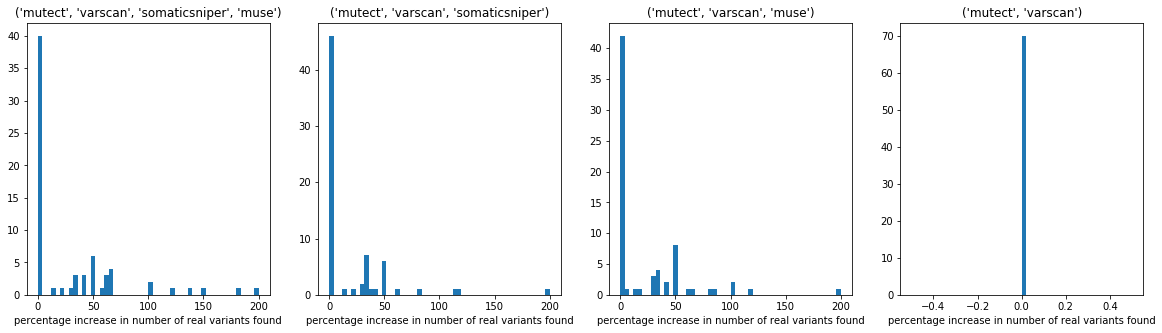

BLCA
+------------------------------------------------+---------------+--------------+----------------+---------------+-------------------+------------------+
| variant callers                                |   mean real % |   real % std |   mean total % |   total % std |   mean all real % |   all real % std |
|------------------------------------------------+---------------+--------------+----------------+---------------+-------------------+------------------|
| ('mutect', 'varscan', 'somaticsniper', 'muse') |        29.345 |       38.036 |          3.947 |         9.718 |           100.000 |            0.000 |
| ('mutect', 'varscan', 'muse')                  |        25.296 |       32.187 |          3.621 |         9.669 |            97.701 |            5.178 |
| ('mutect', 'varscan', 'somaticsniper')         |        17.548 |       25.352 |          0.524 |         1.856 |            92.526 |            9.521 |
| ('mutect', 'varscan')                          |         0.000 |     

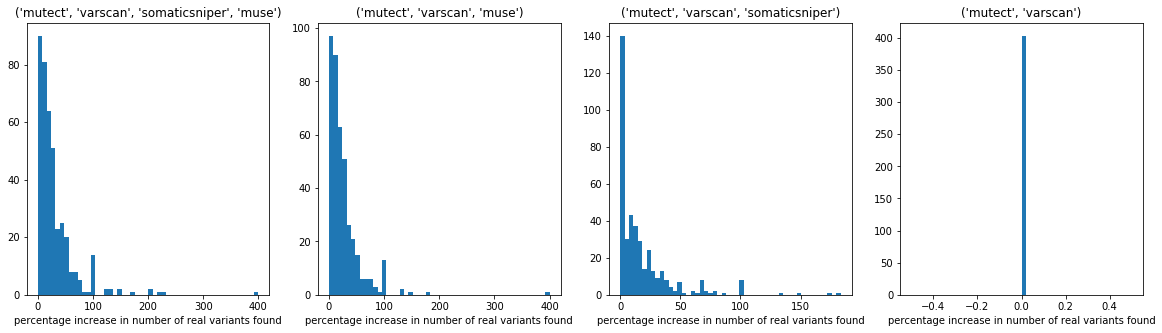

/Users/kathrynleung/bigdatax/somatic_mafs/table.py:83: RuntimeWarning: divide by zero encountered in long_scalars
  tpercent.append(100*((sums['total'][i] - sums['total'][0]) / sums['total'][0]))


BRCA
+------------------------------------------------+---------------+--------------+----------------+---------------+-------------------+------------------+
| variant callers                                |   mean real % |   real % std |   mean total % |   total % std |   mean all real % |   all real % std |
|------------------------------------------------+---------------+--------------+----------------+---------------+-------------------+------------------|
| ('mutect', 'varscan', 'somaticsniper', 'muse') |        22.611 |       42.744 |          4.172 |        14.937 |           100.000 |            0.000 |
| ('mutect', 'varscan', 'muse')                  |        19.733 |       38.589 |          2.531 |        10.657 |            98.247 |            7.188 |
| ('mutect', 'varscan', 'somaticsniper')         |        12.534 |       31.516 |          1.771 |         8.209 |            93.485 |           14.116 |
| ('mutect', 'varscan')                          |         0.000 |     

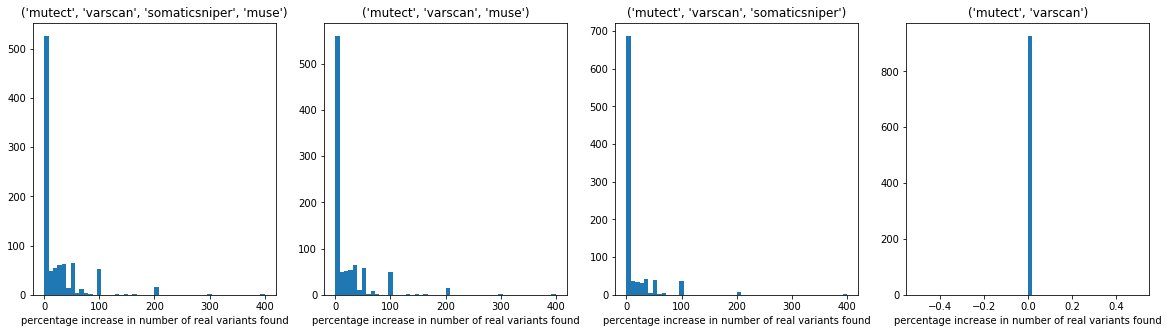

CESC
+------------------------------------------------+---------------+--------------+----------------+---------------+-------------------+------------------+
| variant callers                                |   mean real % |   real % std |   mean total % |   total % std |   mean all real % |   all real % std |
|------------------------------------------------+---------------+--------------+----------------+---------------+-------------------+------------------|
| ('mutect', 'varscan', 'somaticsniper', 'muse') |        20.209 |       29.316 |          5.565 |        12.406 |           100.000 |            0.000 |
| ('mutect', 'varscan', 'muse')                  |        16.973 |       25.548 |          4.214 |        11.217 |            97.955 |            5.988 |
| ('mutect', 'varscan', 'somaticsniper')         |        12.173 |       20.809 |          1.499 |         6.151 |            94.757 |            9.345 |
| ('mutect', 'varscan')                          |         0.000 |     

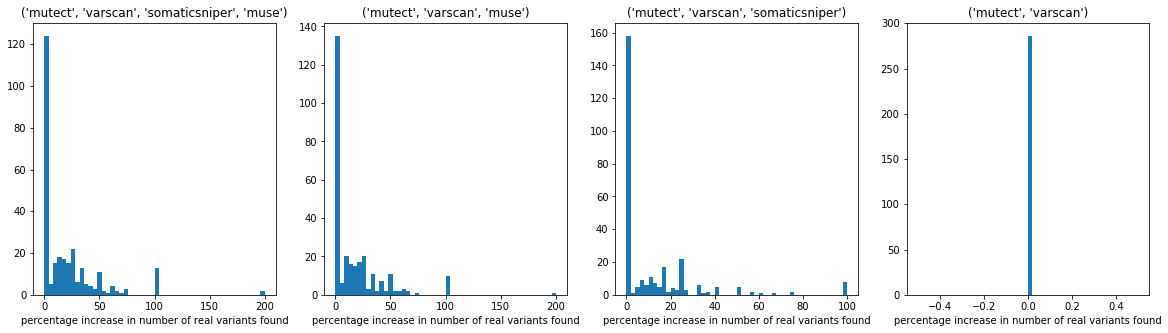

CHOL
+------------------------------------------------+---------------+--------------+----------------+---------------+-------------------+------------------+
| variant callers                                |   mean real % |   real % std |   mean total % |   total % std |   mean all real % |   all real % std |
|------------------------------------------------+---------------+--------------+----------------+---------------+-------------------+------------------|
| ('mutect', 'varscan', 'somaticsniper', 'muse') |        20.284 |       48.381 |          3.780 |        10.535 |           100.000 |            0.000 |
| ('mutect', 'varscan', 'muse')                  |        17.240 |       47.097 |          2.080 |         8.362 |            96.026 |           11.358 |
| ('mutect', 'varscan', 'somaticsniper')         |        15.349 |       46.400 |          2.041 |         7.247 |            96.074 |           11.400 |
| ('mutect', 'varscan')                          |         0.000 |     

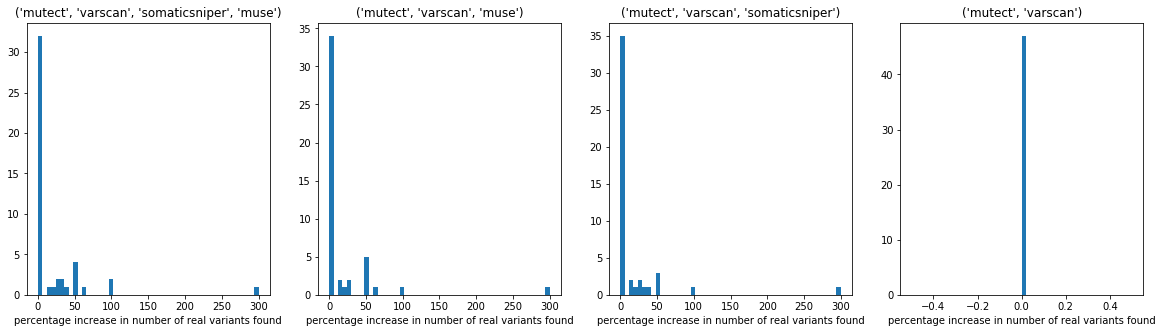

COAD
+------------------------------------------------+---------------+--------------+----------------+---------------+-------------------+------------------+
| variant callers                                |   mean real % |   real % std |   mean total % |   total % std |   mean all real % |   all real % std |
|------------------------------------------------+---------------+--------------+----------------+---------------+-------------------+------------------|
| ('mutect', 'varscan', 'somaticsniper', 'muse') |        24.736 |       27.803 |          2.059 |         5.376 |           100.000 |            0.000 |
| ('mutect', 'varscan', 'muse')                  |        20.732 |       23.408 |          1.433 |         4.853 |            97.460 |            6.208 |
| ('mutect', 'varscan', 'somaticsniper')         |        16.835 |       22.002 |          0.756 |         2.718 |            94.410 |            8.457 |
| ('mutect', 'varscan')                          |         0.000 |     

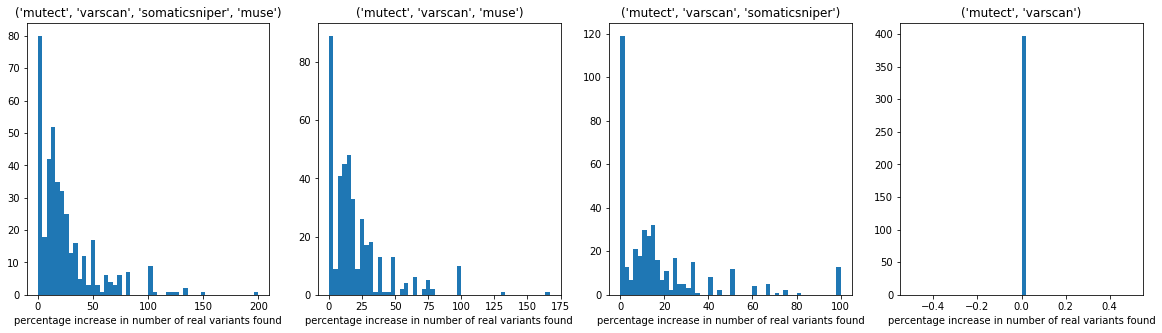

DLBC
+------------------------------------------------+---------------+--------------+----------------+---------------+-------------------+------------------+
| variant callers                                |   mean real % |   real % std |   mean total % |   total % std |   mean all real % |   all real % std |
|------------------------------------------------+---------------+--------------+----------------+---------------+-------------------+------------------|
| ('mutect', 'varscan', 'somaticsniper', 'muse') |        44.385 |       44.165 |          5.343 |         8.919 |           100.000 |            0.000 |
| ('mutect', 'varscan', 'muse')                  |        32.030 |       32.450 |          4.664 |         8.837 |            93.731 |           10.607 |
| ('mutect', 'varscan', 'somaticsniper')         |        34.651 |       38.823 |          1.045 |         2.453 |            89.174 |           23.260 |
| ('mutect', 'varscan')                          |         0.000 |     

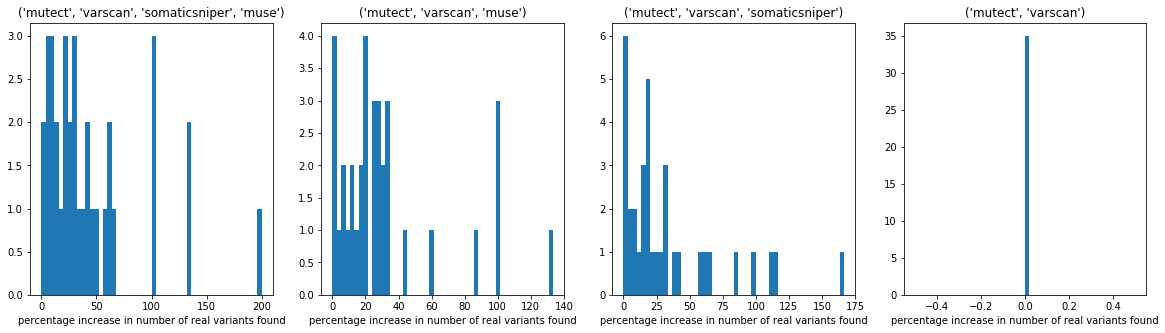

ESCA
+------------------------------------------------+---------------+--------------+----------------+---------------+-------------------+------------------+
| variant callers                                |   mean real % |   real % std |   mean total % |   total % std |   mean all real % |   all real % std |
|------------------------------------------------+---------------+--------------+----------------+---------------+-------------------+------------------|
| ('mutect', 'varscan', 'somaticsniper', 'muse') |        28.219 |       39.776 |          4.495 |         8.648 |           100.000 |            0.000 |
| ('mutect', 'varscan', 'muse')                  |        22.016 |       34.644 |          2.669 |         6.841 |            96.068 |            7.828 |
| ('mutect', 'varscan', 'somaticsniper')         |        19.826 |       34.402 |          2.673 |         6.566 |            94.440 |            8.646 |
| ('mutect', 'varscan')                          |         0.000 |     

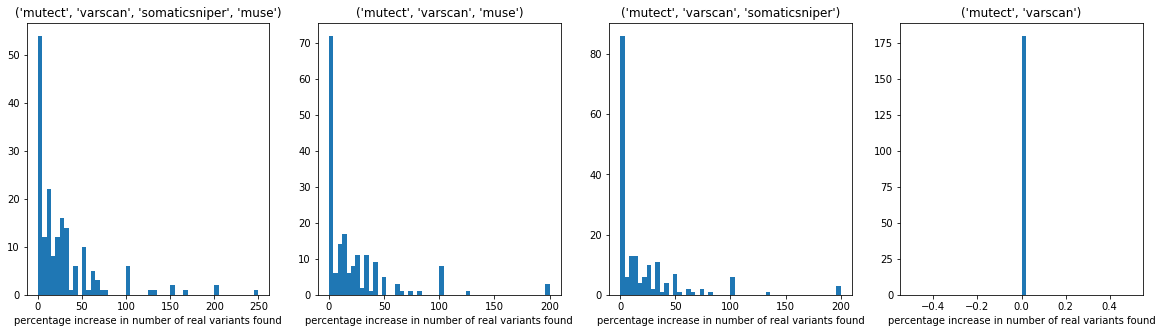

GBM
+------------------------------------------------+---------------+--------------+----------------+---------------+-------------------+------------------+
| variant callers                                |   mean real % |   real % std |   mean total % |   total % std |   mean all real % |   all real % std |
|------------------------------------------------+---------------+--------------+----------------+---------------+-------------------+------------------|
| ('mutect', 'varscan', 'somaticsniper', 'muse') |        45.174 |       65.338 |          3.260 |        11.112 |           100.000 |            0.000 |
| ('mutect', 'varscan', 'muse')                  |        33.528 |       44.627 |          3.013 |        10.899 |            94.838 |           12.209 |
| ('mutect', 'varscan', 'somaticsniper')         |        29.764 |       46.835 |          1.276 |         6.893 |            91.712 |           15.871 |
| ('mutect', 'varscan')                          |         0.000 |      

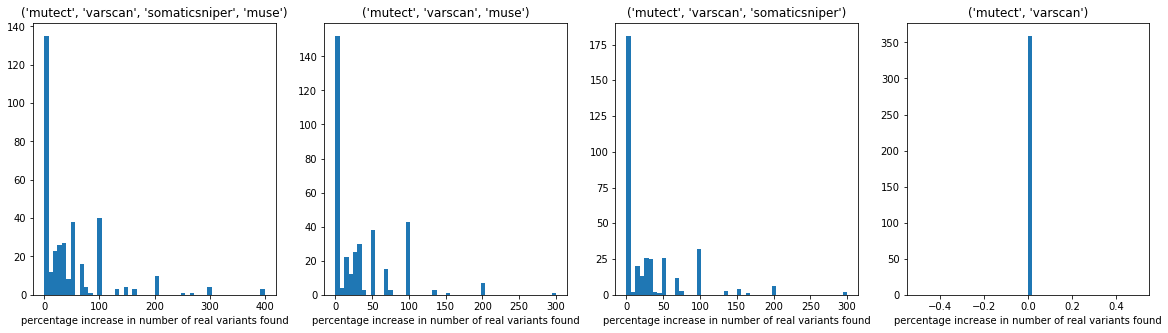

HNSC
+------------------------------------------------+---------------+--------------+----------------+---------------+-------------------+------------------+
| variant callers                                |   mean real % |   real % std |   mean total % |   total % std |   mean all real % |   all real % std |
|------------------------------------------------+---------------+--------------+----------------+---------------+-------------------+------------------|
| ('mutect', 'varscan', 'somaticsniper', 'muse') |        21.872 |       31.816 |          2.083 |         5.934 |           100.000 |            0.000 |
| ('mutect', 'varscan', 'muse')                  |        19.414 |       27.231 |          1.918 |         5.780 |            98.473 |            5.158 |
| ('mutect', 'varscan', 'somaticsniper')         |        11.111 |       20.067 |          0.315 |         1.956 |            93.013 |           11.111 |
| ('mutect', 'varscan')                          |         0.000 |     

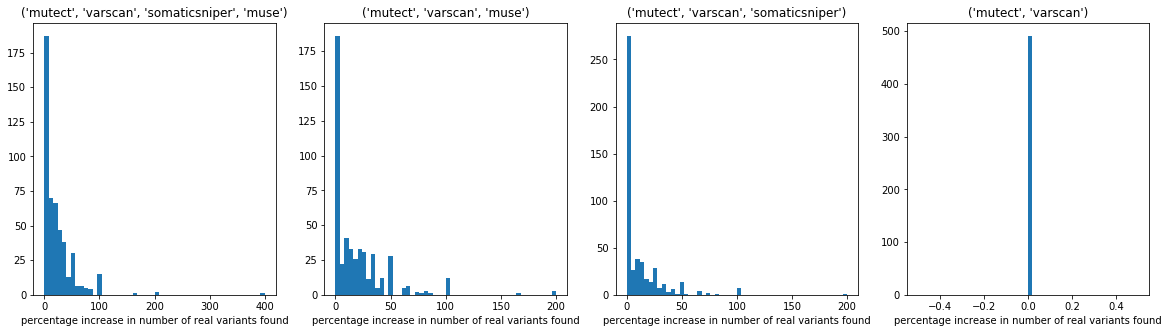

KICH
+------------------------------------------------+---------------+--------------+----------------+---------------+-------------------+------------------+
| variant callers                                |   mean real % |   real % std |   mean total % |   total % std |   mean all real % |   all real % std |
|------------------------------------------------+---------------+--------------+----------------+---------------+-------------------+------------------|
| ('mutect', 'varscan', 'somaticsniper', 'muse') |        22.520 |       39.845 |          5.263 |        17.145 |           100.000 |            0.000 |
| ('mutect', 'varscan', 'somaticsniper')         |        22.278 |       39.854 |          4.678 |        16.741 |            91.506 |           25.657 |
| ('mutect', 'varscan', 'muse')                  |        20.403 |       38.278 |          0.585 |         4.376 |            94.736 |           17.532 |
| ('mutect', 'varscan')                          |         0.000 |     

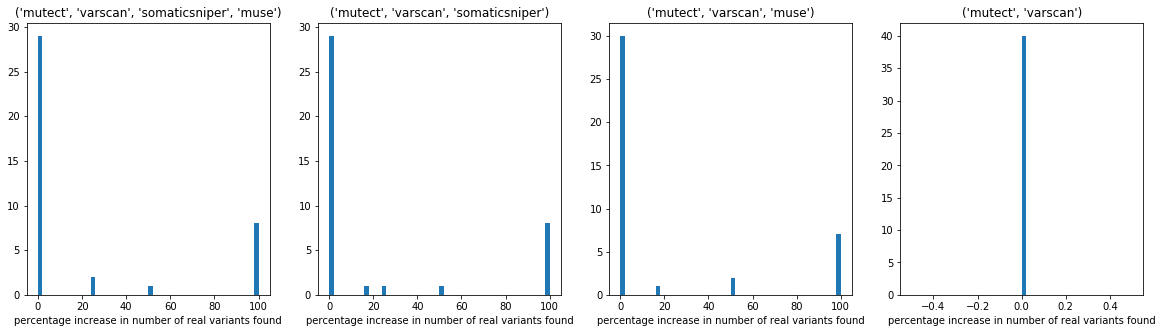

KIRC
+------------------------------------------------+---------------+--------------+----------------+---------------+-------------------+------------------+
| variant callers                                |   mean real % |   real % std |   mean total % |   total % std |   mean all real % |   all real % std |
|------------------------------------------------+---------------+--------------+----------------+---------------+-------------------+------------------|
| ('mutect', 'varscan', 'somaticsniper', 'muse') |        17.462 |       33.438 |          2.898 |        12.459 |           100.000 |            0.000 |
| ('mutect', 'varscan', 'muse')                  |        14.332 |       31.386 |          1.635 |         8.810 |            97.733 |            9.185 |
| ('mutect', 'varscan', 'somaticsniper')         |         8.421 |       23.161 |          1.330 |         9.048 |            92.918 |           16.767 |
| ('mutect', 'varscan')                          |         0.000 |     

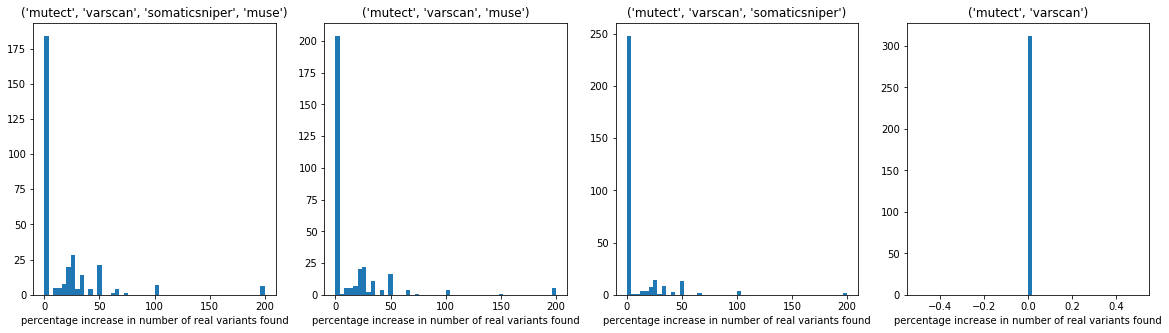

KIRP
+------------------------------------------------+---------------+--------------+----------------+---------------+-------------------+------------------+
| variant callers                                |   mean real % |   real % std |   mean total % |   total % std |   mean all real % |   all real % std |
|------------------------------------------------+---------------+--------------+----------------+---------------+-------------------+------------------|
| ('mutect', 'varscan', 'somaticsniper', 'muse') |        15.960 |       28.190 |          3.566 |        14.364 |           100.000 |            0.000 |
| ('mutect', 'varscan', 'muse')                  |        12.435 |       24.712 |          1.994 |        10.239 |            96.975 |           12.046 |
| ('mutect', 'varscan', 'somaticsniper')         |        11.175 |       22.633 |          1.572 |         8.229 |            95.406 |           14.975 |
| ('mutect', 'varscan')                          |         0.000 |     

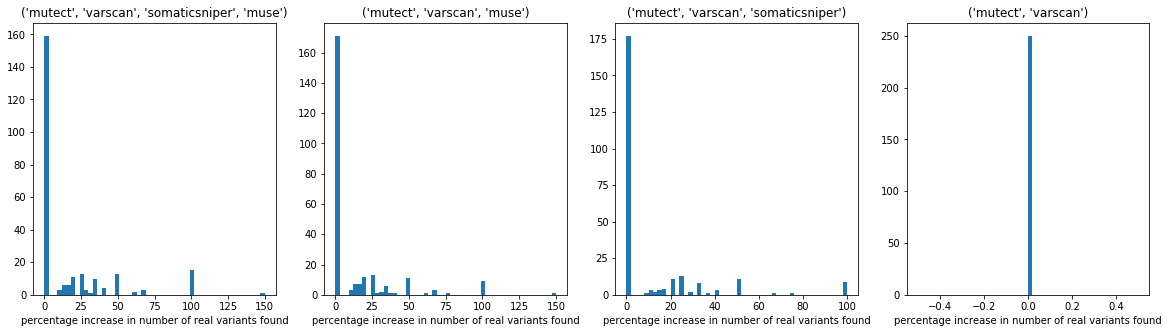

LAML
+------------------------------------------------+---------------+--------------+----------------+---------------+-------------------+------------------+
| variant callers                                |   mean real % |   real % std |   mean total % |   total % std |   mean all real % |   all real % std |
|------------------------------------------------+---------------+--------------+----------------+---------------+-------------------+------------------|
| ('mutect', 'varscan', 'somaticsniper', 'muse') |        70.169 |       90.580 |         19.951 |        48.435 |           100.000 |            0.000 |
| ('mutect', 'varscan', 'somaticsniper')         |        54.788 |       82.005 |         19.088 |        48.421 |            93.658 |           18.092 |
| ('mutect', 'varscan', 'muse')                  |        26.248 |       54.521 |          1.857 |        11.137 |            67.902 |           38.355 |
| ('mutect', 'varscan')                          |         0.000 |     

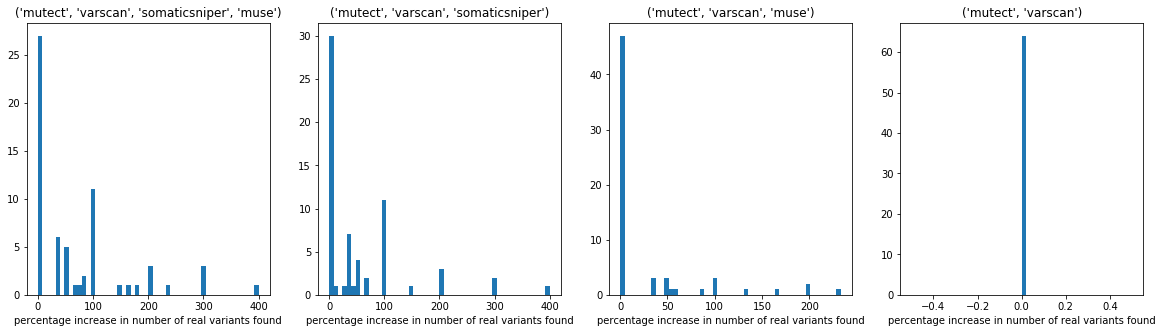

LGG
+------------------------------------------------+---------------+--------------+----------------+---------------+-------------------+------------------+
| variant callers                                |   mean real % |   real % std |   mean total % |   total % std |   mean all real % |   all real % std |
|------------------------------------------------+---------------+--------------+----------------+---------------+-------------------+------------------|
| ('mutect', 'varscan', 'somaticsniper', 'muse') |        37.886 |       59.404 |          3.559 |        23.160 |           100.000 |            0.000 |
| ('mutect', 'varscan', 'muse')                  |        30.503 |       47.163 |          3.341 |        23.080 |            96.584 |            9.104 |
| ('mutect', 'varscan', 'somaticsniper')         |        26.467 |       44.317 |          0.421 |         3.199 |            93.963 |           12.797 |
| ('mutect', 'varscan')                          |         0.000 |      

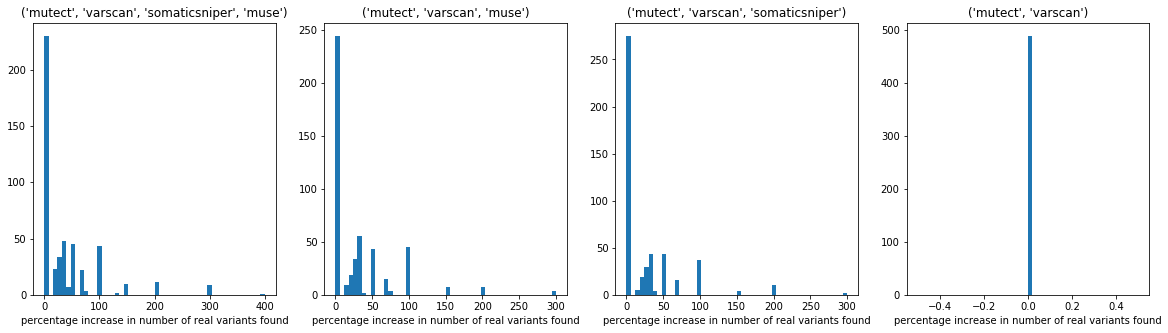

LIHC
+------------------------------------------------+---------------+--------------+----------------+---------------+-------------------+------------------+
| variant callers                                |   mean real % |   real % std |   mean total % |   total % std |   mean all real % |   all real % std |
|------------------------------------------------+---------------+--------------+----------------+---------------+-------------------+------------------|
| ('mutect', 'varscan', 'somaticsniper', 'muse') |        19.499 |       35.058 |          2.252 |         6.770 |           100.000 |            0.000 |
| ('mutect', 'varscan', 'muse')                  |        15.759 |       31.206 |          1.547 |         5.740 |            97.496 |            7.262 |
| ('mutect', 'varscan', 'somaticsniper')         |        13.501 |       27.257 |          0.822 |         4.023 |            94.596 |           14.929 |
| ('mutect', 'varscan')                          |         0.000 |     

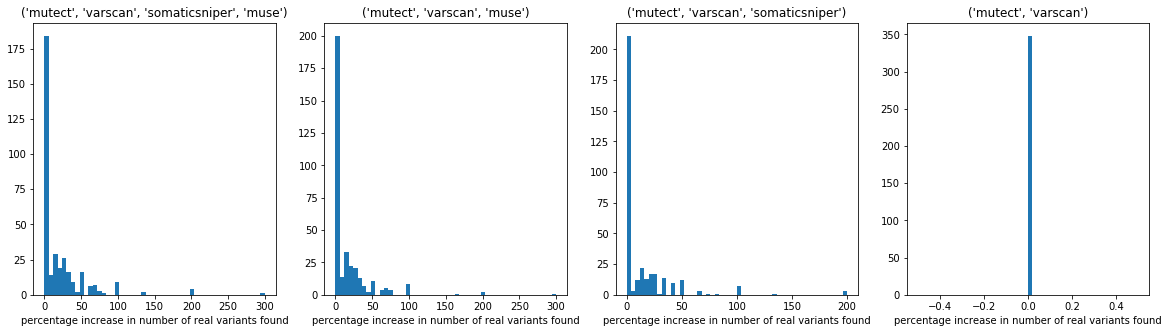

LUAD
+------------------------------------------------+---------------+--------------+----------------+---------------+-------------------+------------------+
| variant callers                                |   mean real % |   real % std |   mean total % |   total % std |   mean all real % |   all real % std |
|------------------------------------------------+---------------+--------------+----------------+---------------+-------------------+------------------|
| ('mutect', 'varscan', 'somaticsniper', 'muse') |        27.356 |       40.529 |          2.402 |         7.719 |           100.000 |            0.000 |
| ('mutect', 'varscan', 'muse')                  |        22.429 |       31.742 |          1.930 |         7.249 |            96.853 |            9.733 |
| ('mutect', 'varscan', 'somaticsniper')         |        13.093 |       31.038 |          0.720 |         5.159 |            90.247 |           14.515 |
| ('mutect', 'varscan')                          |         0.000 |     

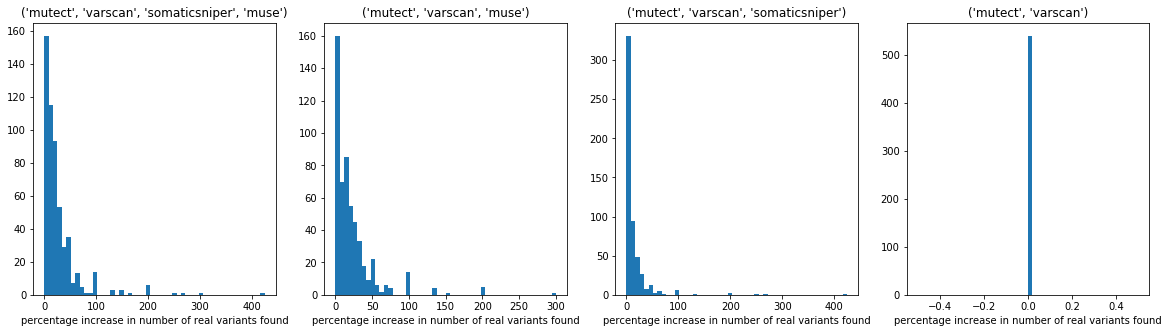

LUSC
+------------------------------------------------+---------------+--------------+----------------+---------------+-------------------+------------------+
| variant callers                                |   mean real % |   real % std |   mean total % |   total % std |   mean all real % |   all real % std |
|------------------------------------------------+---------------+--------------+----------------+---------------+-------------------+------------------|
| ('mutect', 'varscan', 'somaticsniper', 'muse') |        22.992 |       35.426 |          2.710 |         6.630 |           100.000 |            0.000 |
| ('mutect', 'varscan', 'muse')                  |        19.518 |       32.910 |          2.422 |         6.458 |            97.507 |            7.065 |
| ('mutect', 'varscan', 'somaticsniper')         |        11.570 |       20.068 |          0.482 |         1.831 |            92.328 |           10.468 |
| ('mutect', 'varscan')                          |         0.000 |     

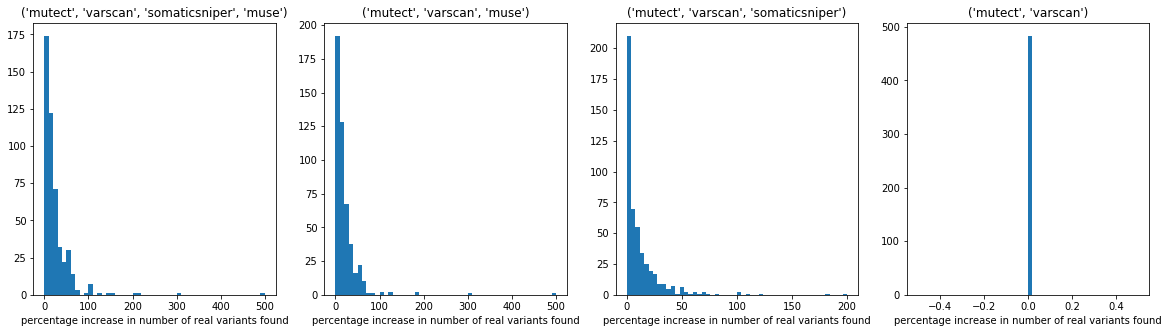

MESO
+------------------------------------------------+---------------+--------------+----------------+---------------+-------------------+------------------+
| variant callers                                |   mean real % |   real % std |   mean total % |   total % std |   mean all real % |   all real % std |
|------------------------------------------------+---------------+--------------+----------------+---------------+-------------------+------------------|
| ('mutect', 'varscan', 'somaticsniper', 'muse') |        20.246 |       40.222 |          1.570 |         5.939 |           100.000 |            0.000 |
| ('mutect', 'varscan', 'muse')                  |        17.311 |       35.046 |          1.065 |         4.653 |            97.185 |           13.017 |
| ('mutect', 'varscan', 'somaticsniper')         |         8.400 |       22.962 |          0.504 |         3.833 |            94.290 |           14.747 |
| ('mutect', 'varscan')                          |         0.000 |     

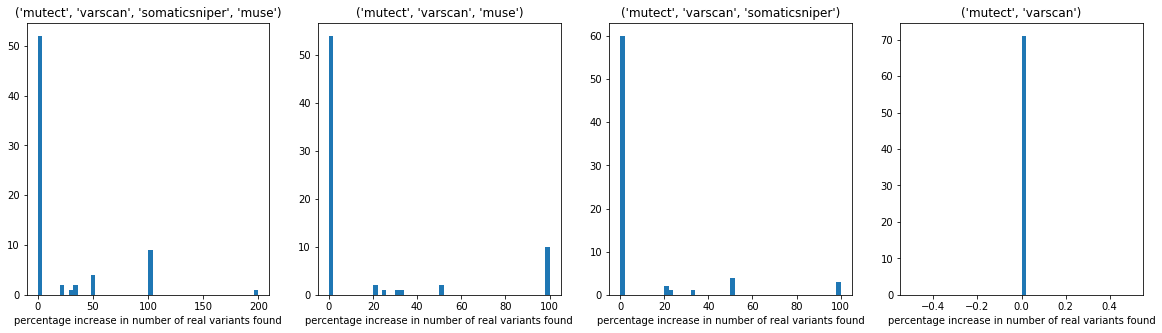

OV
+------------------------------------------------+---------------+--------------+----------------+---------------+-------------------+------------------+
| variant callers                                |   mean real % |   real % std |   mean total % |   total % std |   mean all real % |   all real % std |
|------------------------------------------------+---------------+--------------+----------------+---------------+-------------------+------------------|
| ('mutect', 'varscan', 'somaticsniper', 'muse') |        61.445 |       80.662 |          2.881 |         8.504 |           100.000 |            0.000 |
| ('mutect', 'varscan', 'muse')                  |        45.509 |       62.241 |          2.469 |         7.987 |            92.167 |           14.878 |
| ('mutect', 'varscan', 'somaticsniper')         |        35.669 |       49.959 |          0.783 |         4.114 |            88.055 |           16.664 |
| ('mutect', 'varscan')                          |         0.000 |       

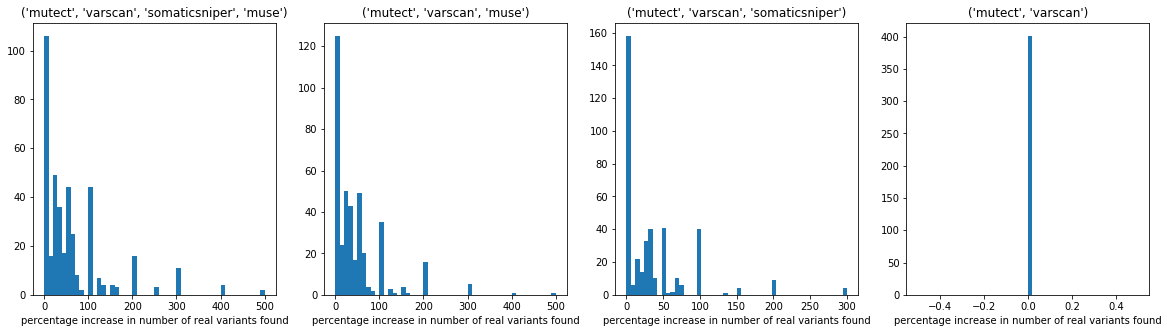

PAAD
+------------------------------------------------+---------------+--------------+----------------+---------------+-------------------+------------------+
| variant callers                                |   mean real % |   real % std |   mean total % |   total % std |   mean all real % |   all real % std |
|------------------------------------------------+---------------+--------------+----------------+---------------+-------------------+------------------|
| ('mutect', 'varscan', 'somaticsniper', 'muse') |        45.505 |       66.257 |          2.531 |         7.972 |           100.000 |            0.000 |
| ('mutect', 'varscan', 'muse')                  |        43.921 |       65.919 |          2.212 |         6.995 |            98.939 |            4.619 |
| ('mutect', 'varscan', 'somaticsniper')         |        12.494 |       29.043 |          0.497 |         4.508 |            80.664 |           27.253 |
| ('mutect', 'varscan')                          |         0.000 |     

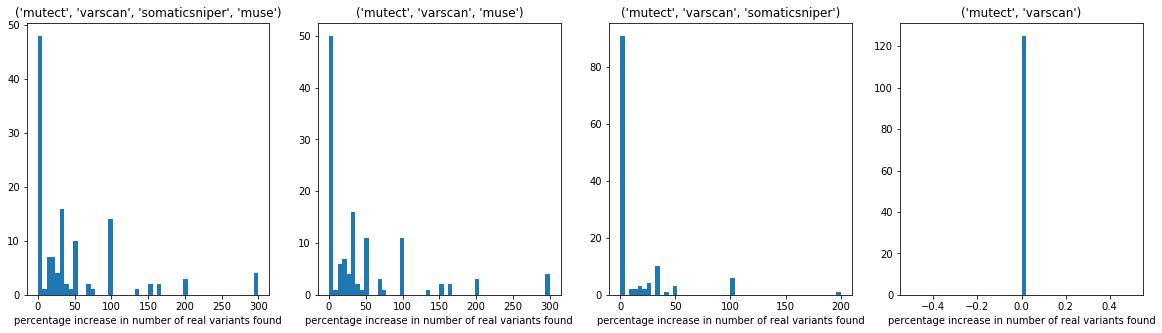

PCPG
+------------------------------------------------+---------------+--------------+----------------+---------------+-------------------+------------------+
| variant callers                                |   mean real % |   real % std |   mean total % |   total % std |   mean all real % |   all real % std |
|------------------------------------------------+---------------+--------------+----------------+---------------+-------------------+------------------|
| ('mutect', 'varscan', 'somaticsniper', 'muse') |         6.316 |       23.218 |          2.193 |        13.877 |           100.000 |            0.000 |
| ('mutect', 'varscan', 'somaticsniper')         |         4.737 |       20.614 |          0.000 |         0.000 |            98.667 |            7.703 |
| ('mutect', 'varscan', 'muse')                  |         5.789 |       22.784 |          2.193 |        13.877 |            98.167 |           11.522 |
| ('mutect', 'varscan')                          |         0.000 |     

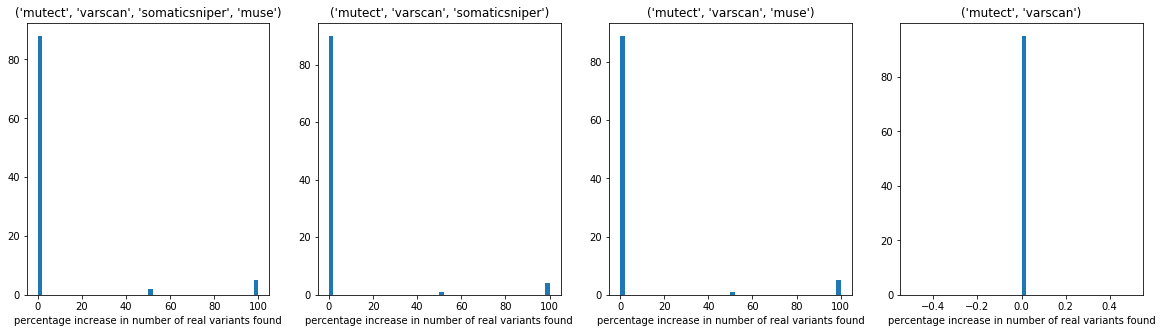

PRAD
+------------------------------------------------+---------------+--------------+----------------+---------------+-------------------+------------------+
| variant callers                                |   mean real % |   real % std |   mean total % |   total % std |   mean all real % |   all real % std |
|------------------------------------------------+---------------+--------------+----------------+---------------+-------------------+------------------|
| ('mutect', 'varscan', 'somaticsniper', 'muse') |        17.366 |       42.214 |          2.222 |        11.999 |           100.000 |            0.000 |
| ('mutect', 'varscan', 'muse')                  |        14.583 |       38.803 |          2.054 |        11.737 |            98.217 |            8.947 |
| ('mutect', 'varscan', 'somaticsniper')         |         8.132 |       24.672 |          0.480 |         5.762 |            91.882 |           21.643 |
| ('mutect', 'varscan')                          |         0.000 |     

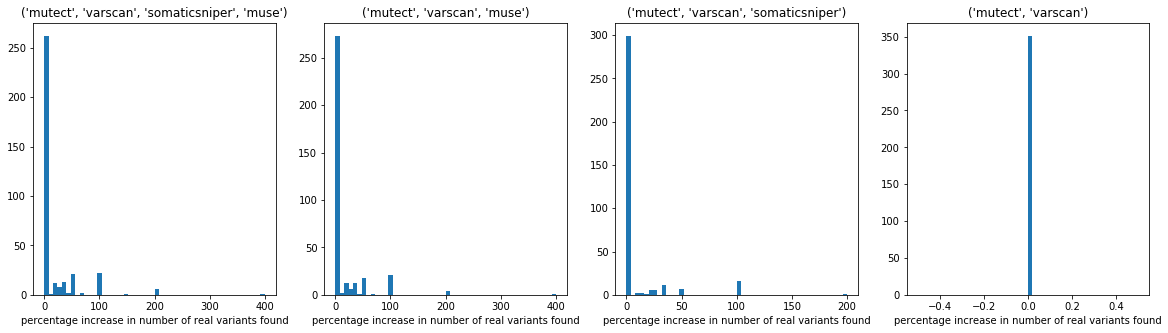

READ
+------------------------------------------------+---------------+--------------+----------------+---------------+-------------------+------------------+
| variant callers                                |   mean real % |   real % std |   mean total % |   total % std |   mean all real % |   all real % std |
|------------------------------------------------+---------------+--------------+----------------+---------------+-------------------+------------------|
| ('mutect', 'varscan', 'somaticsniper', 'muse') |        30.761 |       32.374 |          1.460 |         3.891 |           100.000 |            0.000 |
| ('mutect', 'varscan', 'muse')                  |        25.494 |       27.132 |          1.010 |         3.437 |            96.801 |            6.321 |
| ('mutect', 'varscan', 'somaticsniper')         |        21.934 |       24.874 |          0.624 |         2.415 |            94.506 |            8.686 |
| ('mutect', 'varscan')                          |         0.000 |     

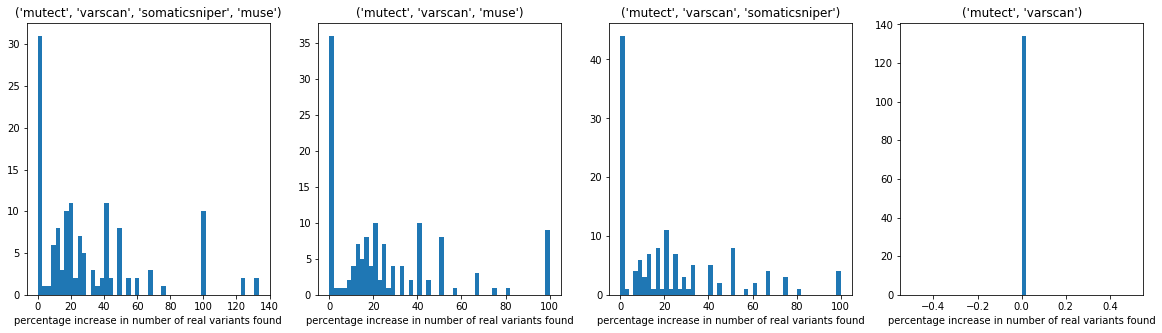

SARC
+------------------------------------------------+---------------+--------------+----------------+---------------+-------------------+------------------+
| variant callers                                |   mean real % |   real % std |   mean total % |   total % std |   mean all real % |   all real % std |
|------------------------------------------------+---------------+--------------+----------------+---------------+-------------------+------------------|
| ('mutect', 'varscan', 'somaticsniper', 'muse') |        31.614 |       54.970 |          5.847 |        17.644 |           100.000 |            0.000 |
| ('mutect', 'varscan', 'muse')                  |        23.447 |       41.023 |          2.374 |        12.899 |            95.088 |           14.594 |
| ('mutect', 'varscan', 'somaticsniper')         |        22.076 |       43.417 |          3.662 |        12.506 |            94.922 |           12.194 |
| ('mutect', 'varscan')                          |         0.000 |     

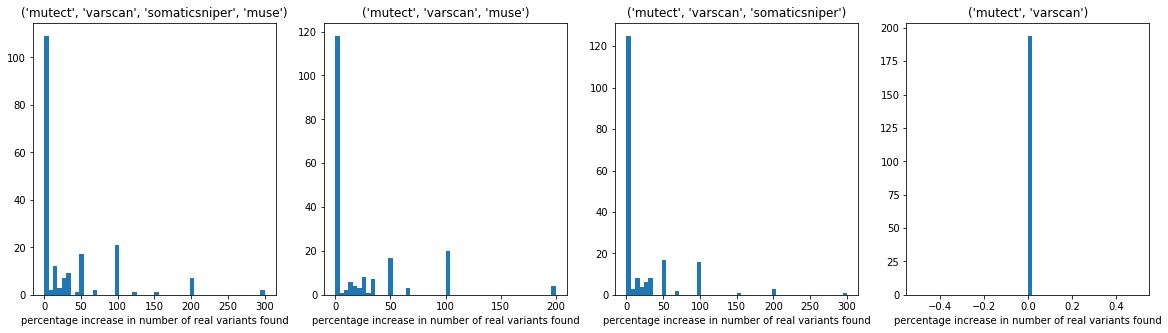

SKCM
+------------------------------------------------+---------------+--------------+----------------+---------------+-------------------+------------------+
| variant callers                                |   mean real % |   real % std |   mean total % |   total % std |   mean all real % |   all real % std |
|------------------------------------------------+---------------+--------------+----------------+---------------+-------------------+------------------|
| ('mutect', 'varscan', 'somaticsniper', 'muse') |        24.558 |       28.851 |          1.487 |         4.354 |           100.000 |            0.000 |
| ('mutect', 'varscan', 'muse')                  |        21.046 |       24.273 |          1.258 |         3.623 |            97.424 |            6.286 |
| ('mutect', 'varscan', 'somaticsniper')         |        16.097 |       21.800 |          0.400 |         2.582 |            93.662 |           10.775 |
| ('mutect', 'varscan')                          |         0.000 |     

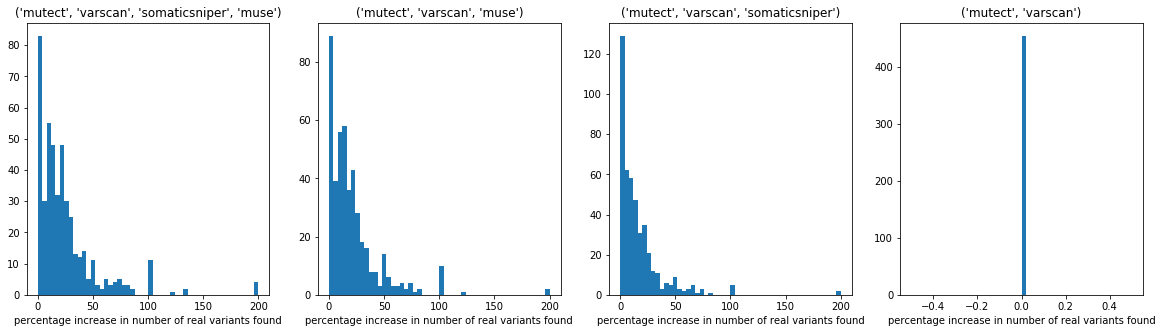

STAD
+------------------------------------------------+---------------+--------------+----------------+---------------+-------------------+------------------+
| variant callers                                |   mean real % |   real % std |   mean total % |   total % std |   mean all real % |   all real % std |
|------------------------------------------------+---------------+--------------+----------------+---------------+-------------------+------------------|
| ('mutect', 'varscan', 'somaticsniper', 'muse') |        24.139 |       31.616 |          1.610 |         5.183 |           100.000 |            0.000 |
| ('mutect', 'varscan', 'muse')                  |        21.768 |       29.458 |          1.392 |         4.950 |            98.000 |            8.163 |
| ('mutect', 'varscan', 'somaticsniper')         |        10.940 |       20.414 |          0.327 |         2.043 |            91.260 |           12.657 |
| ('mutect', 'varscan')                          |         0.000 |     

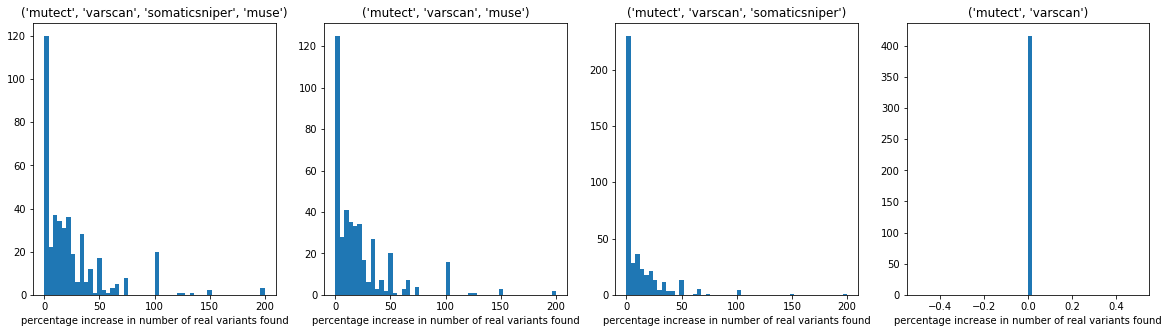

TGCT
+------------------------------------------------+---------------+--------------+----------------+---------------+-------------------+------------------+
| variant callers                                |   mean real % |   real % std |   mean total % |   total % std |   mean all real % |   all real % std |
|------------------------------------------------+---------------+--------------+----------------+---------------+-------------------+------------------|
| ('mutect', 'varscan', 'somaticsniper', 'muse') |         9.829 |       27.662 |          2.700 |        13.104 |           100.000 |            0.000 |
| ('mutect', 'varscan', 'muse')                  |         8.761 |       27.180 |          0.000 |         0.000 |            99.289 |            4.546 |
| ('mutect', 'varscan', 'somaticsniper')         |         2.350 |       12.999 |          2.700 |        13.104 |            95.020 |           16.455 |
| ('mutect', 'varscan')                          |         0.000 |     

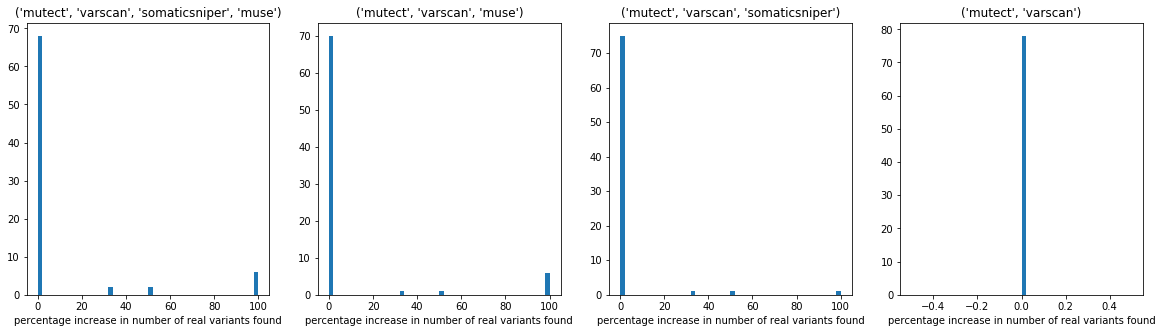

THCA
+------------------------------------------------+---------------+--------------+----------------+---------------+-------------------+------------------+
| variant callers                                |   mean real % |   real % std |   mean total % |   total % std |   mean all real % |   all real % std |
|------------------------------------------------+---------------+--------------+----------------+---------------+-------------------+------------------|
| ('mutect', 'varscan', 'somaticsniper', 'muse') |         7.733 |       28.661 |          1.555 |        14.693 |           100.000 |            0.000 |
| ('mutect', 'varscan', 'muse')                  |         6.999 |       26.332 |          1.555 |        14.693 |            99.048 |            8.142 |
| ('mutect', 'varscan', 'somaticsniper')         |         3.765 |       19.451 |          0.000 |         0.000 |            97.240 |           12.605 |
| ('mutect', 'varscan')                          |         0.000 |     

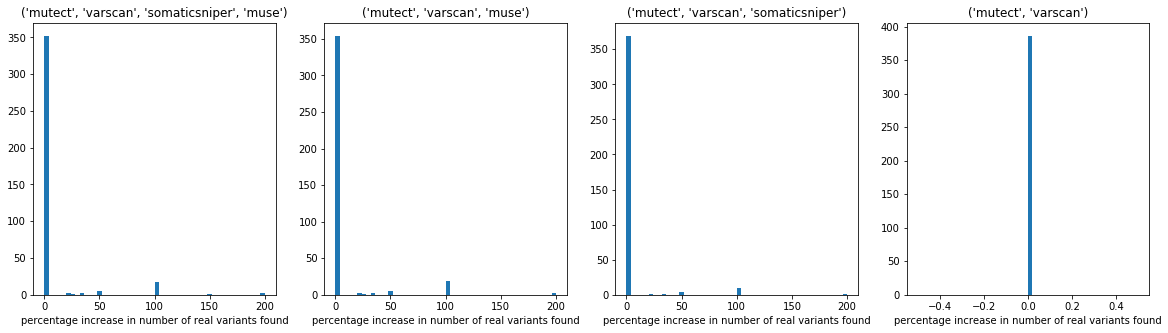

THYM
+------------------------------------------------+---------------+--------------+----------------+---------------+-------------------+------------------+
| variant callers                                |   mean real % |   real % std |   mean total % |   total % std |   mean all real % |   all real % std |
|------------------------------------------------+---------------+--------------+----------------+---------------+-------------------+------------------|
| ('mutect', 'varscan', 'somaticsniper', 'muse') |        21.930 |       37.517 |          4.427 |        18.690 |           100.000 |            0.000 |
| ('mutect', 'varscan', 'muse')                  |        17.473 |       35.064 |          1.302 |         7.398 |            97.443 |            9.241 |
| ('mutect', 'varscan', 'somaticsniper')         |        10.496 |       26.962 |          3.646 |        17.792 |            94.034 |           15.060 |
| ('mutect', 'varscan')                          |         0.000 |     

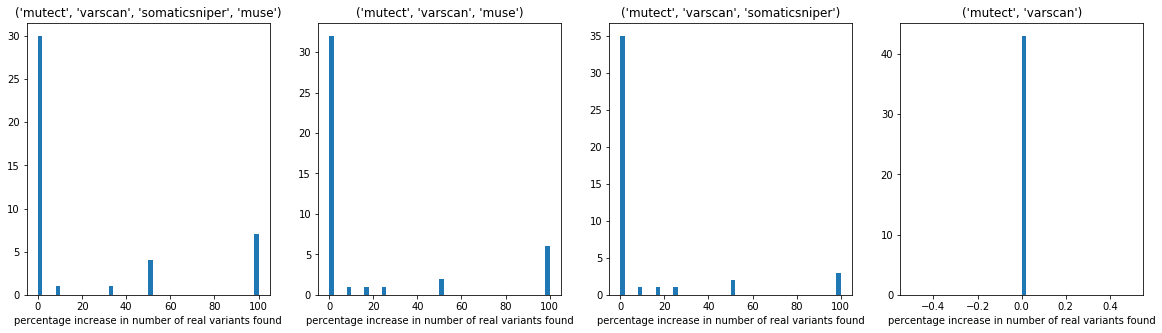

UCEC
+------------------------------------------------+---------------+--------------+----------------+---------------+-------------------+------------------+
| variant callers                                |   mean real % |   real % std |   mean total % |   total % std |   mean all real % |   all real % std |
|------------------------------------------------+---------------+--------------+----------------+---------------+-------------------+------------------|
| ('mutect', 'varscan', 'somaticsniper', 'muse') |        28.087 |       54.579 |          2.663 |         6.824 |           100.000 |            0.000 |
| ('mutect', 'varscan', 'muse')                  |        22.567 |       38.670 |          1.789 |         5.550 |            97.044 |            6.881 |
| ('mutect', 'varscan', 'somaticsniper')         |        20.151 |       39.512 |          1.156 |         4.659 |            95.192 |            7.749 |
| ('mutect', 'varscan')                          |         0.000 |     

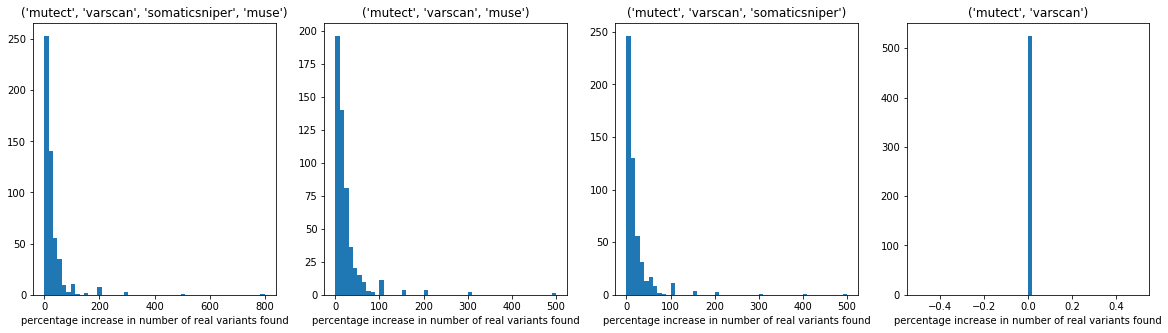

UCS
+------------------------------------------------+---------------+--------------+----------------+---------------+-------------------+------------------+
| variant callers                                |   mean real % |   real % std |   mean total % |   total % std |   mean all real % |   all real % std |
|------------------------------------------------+---------------+--------------+----------------+---------------+-------------------+------------------|
| ('mutect', 'varscan', 'somaticsniper', 'muse') |        80.024 |       79.147 |          2.858 |         5.906 |           100.000 |            0.000 |
| ('mutect', 'varscan', 'muse')                  |        64.756 |       69.467 |          1.852 |         4.921 |            92.747 |            9.800 |
| ('mutect', 'varscan', 'somaticsniper')         |        61.445 |       64.179 |          2.042 |         5.429 |            91.583 |           10.327 |
| ('mutect', 'varscan')                          |         0.000 |      

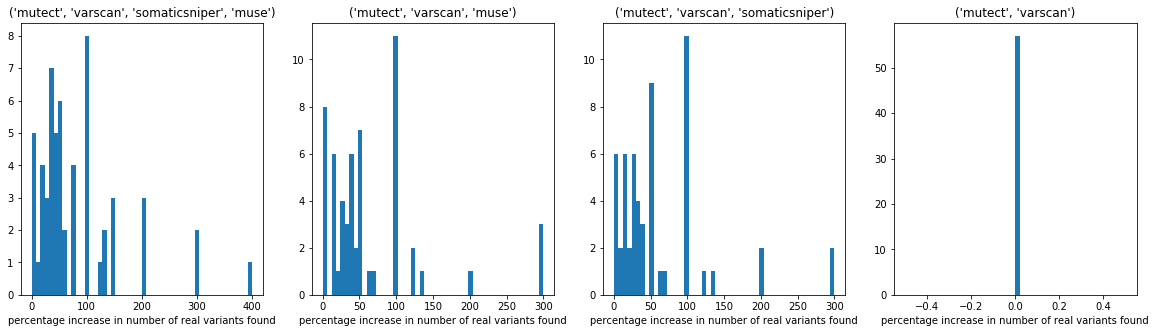

UVM
+------------------------------------------------+---------------+--------------+----------------+---------------+-------------------+------------------+
| variant callers                                |   mean real % |   real % std |   mean total % |   total % std |   mean all real % |   all real % std |
|------------------------------------------------+---------------+--------------+----------------+---------------+-------------------+------------------|
| ('mutect', 'varscan', 'somaticsniper', 'muse') |        34.008 |       64.099 |          2.896 |        12.736 |           100.000 |            0.000 |
| ('mutect', 'varscan', 'muse')                  |        22.110 |       35.855 |          0.917 |         4.801 |            95.868 |           11.996 |
| ('mutect', 'varscan', 'somaticsniper')         |        22.321 |       46.689 |          2.896 |        12.736 |            94.931 |           12.390 |
| ('mutect', 'varscan')                          |         0.000 |      

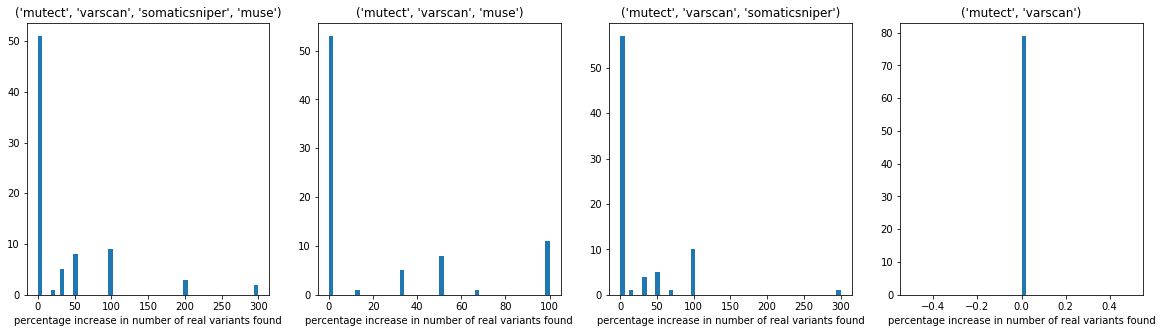

In [474]:
for cancer in possible_cancers:
    # allrealdiff
    ave, real = individual_analysis(original, cancer, possible_callers, tabu = True)
    realhist = dict([(ind, []) for ind in ave.index])
    df = pd.DataFrame(0, index=ave.index, columns=['0%', '> 0%', '>= 25%', 
                                                   '>= 50%', '>= 75%', '>= 100%'])
    # 0% increase, greater than 0, greater than 25, greater than 75, greater than 100
    zc = []
    z = []
    tf = []
    f = []
    sf = []
    oh = []
    for i in range(len(ave.index)):
        
        zerocount = [j for j in real[:,i] if j == 0]
        zero = [j for j in real[:,i] if j > 0]
        twenty_five = [j for j in real[:,i] if j >= 25]
        fifty = [j for j in real[:,i] if j >= 50]
        seventy_five = [j for j in real[:,i] if j >=75]
        one_hundred = [j for j in real[:,i] if j >=100]
        
        realhist[ave.index[i]]=real[:,i]
    
        
        zc.append(len(zerocount)/len(realhist[ave.index[i]]))
        
        z.append(len(zero)/len(realhist[ave.index[i]]))
        
        tf.append(len(twenty_five)/len(realhist[ave.index[i]]))
        
        f.append(len(fifty)/len(realhist[ave.index[i]]))
        
        sf.append(len(seventy_five)/len(realhist[ave.index[i]]))
        
        oh.append(len(one_hundred)/len(realhist[ave.index[i]]))
    
        counts = np.histogram(realhist[ave.index[i]], bins = 50)
    fig, ax = pyplot.subplots(1,4, figsize = (20,5))
    ax[0].hist(realhist[ave.index[0]], bins = 50)
    ax[0].set_title(ave.index[0])
    ax[0].set_xlabel('percentage increase in number of real variants found')
    ax[1].hist(realhist[ave.index[1]], bins = 50)
    ax[1].set_title(ave.index[1])
    ax[1].set_xlabel('percentage increase in number of real variants found')
    ax[2].hist(realhist[ave.index[2]], bins = 50)
    ax[2].set_title(ave.index[2])
    ax[2].set_xlabel('percentage increase in number of real variants found')
    ax[3].hist(realhist[ave.index[3]], bins = 50)
    ax[3].set_title(ave.index[3])
    ax[3].set_xlabel('percentage increase in number of real variants found')
    df['0%'] = zc
    df['> 0%'] = z
    df['>= 25%'] = tf
    df['>= 50%'] = f
    df['>= 75%'] = sf
    df['>= 100%'] = oh
    print(tabulate(df, headers=['variant callers', '= 0%', '> 0%', '>= 25%', '>= 50%', '>= 75%', '>= 100%'], tablefmt='psql',floatfmt=(".0f",".3f",".3f", ".3f",".3f",".3f", ".3f")))
    pyplot.show()
    #print(realhist)

In [468]:
os.chdir(original)
tcga= pd.read_excel(open('TCGA-CDR-SupplementalTableS1.xlsx', 'rb'), sheet_name='TCGA-CDR')

In [469]:
import re
ascat = pd.read_csv('ascat_acf_ploidy.tsv', sep='\t', header=0)
ascat_patients = []

for patient in ascat['Sample']:
    replaced = re.sub('[.]', '-', patient[:12])
    ascat_patients.append(replaced)
    
ascat['Sample'] = ascat_patients

cgc = pd.read_csv('Cancer_Gene_Census_all_Jun-11-2019.csv', usecols = (0,9))

/Users/kathrynleung/bigdatax/somatic_mafs/table.py:70: RuntimeWarning: invalid value encountered in true_divide
  fractions = 100*(tops/realsum)
/Users/kathrynleung/bigdatax/somatic_mafs/table.py:77: RuntimeWarning: invalid value encountered in long_scalars
  rpercent.append(100*((sums['real'][i] - sums['real'][0]) / sums['real'][0]))
/Users/kathrynleung/bigdatax/somatic_mafs/table.py:83: RuntimeWarning: invalid value encountered in long_scalars
  tpercent.append(100*((sums['total'][i] - sums['total'][0]) / sums['total'][0]))
/Users/kathrynleung/bigdatax/somatic_mafs/table.py:77: RuntimeWarning: divide by zero encountered in long_scalars
  rpercent.append(100*((sums['real'][i] - sums['real'][0]) / sums['real'][0]))


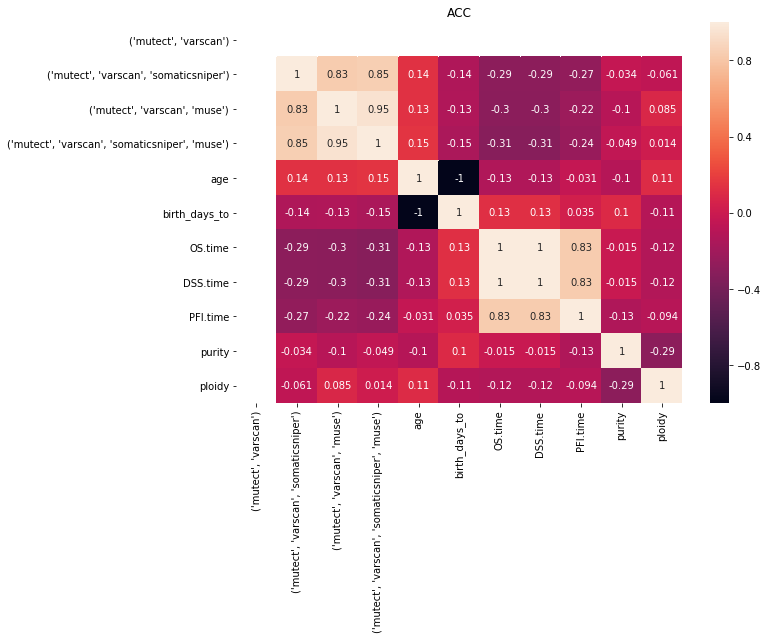

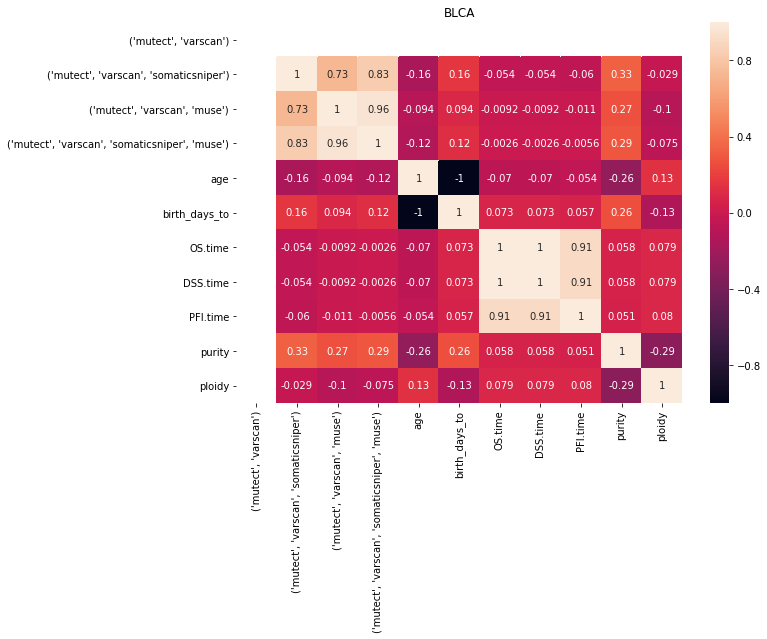

/Users/kathrynleung/bigdatax/somatic_mafs/table.py:83: RuntimeWarning: divide by zero encountered in long_scalars
  tpercent.append(100*((sums['total'][i] - sums['total'][0]) / sums['total'][0]))


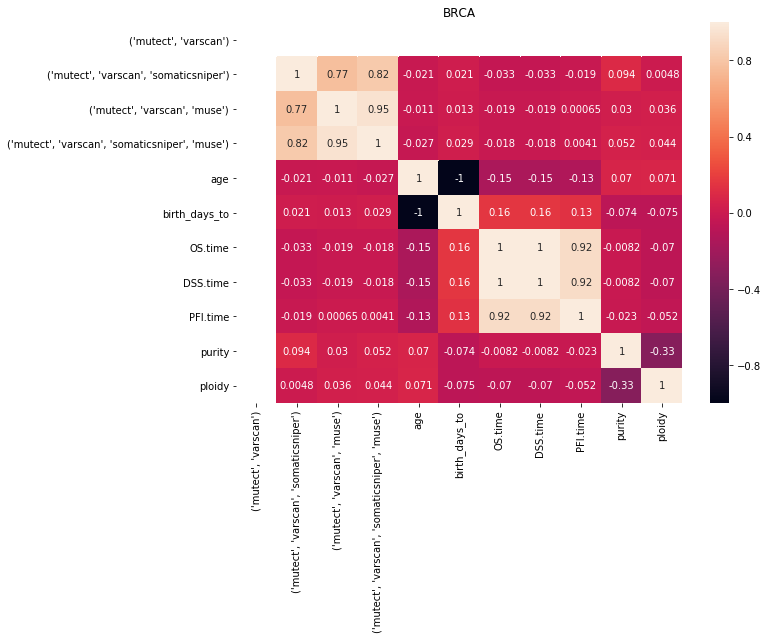

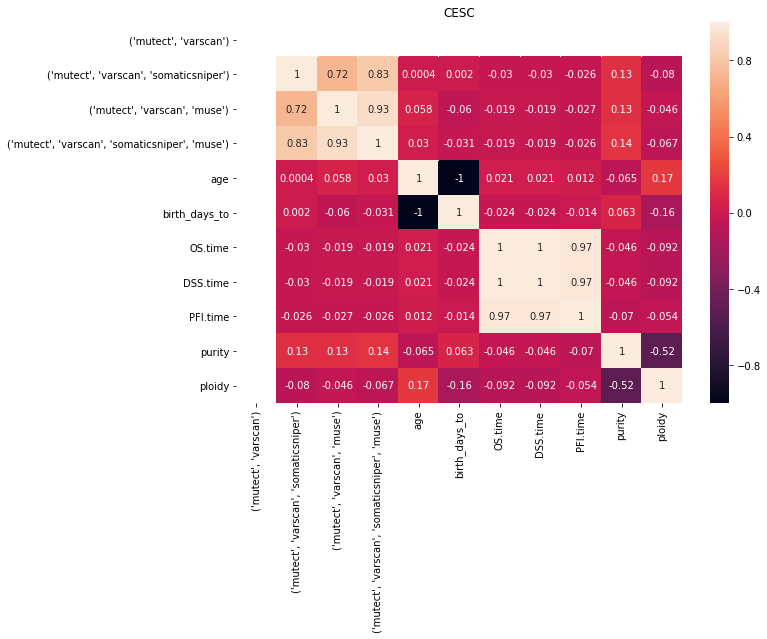

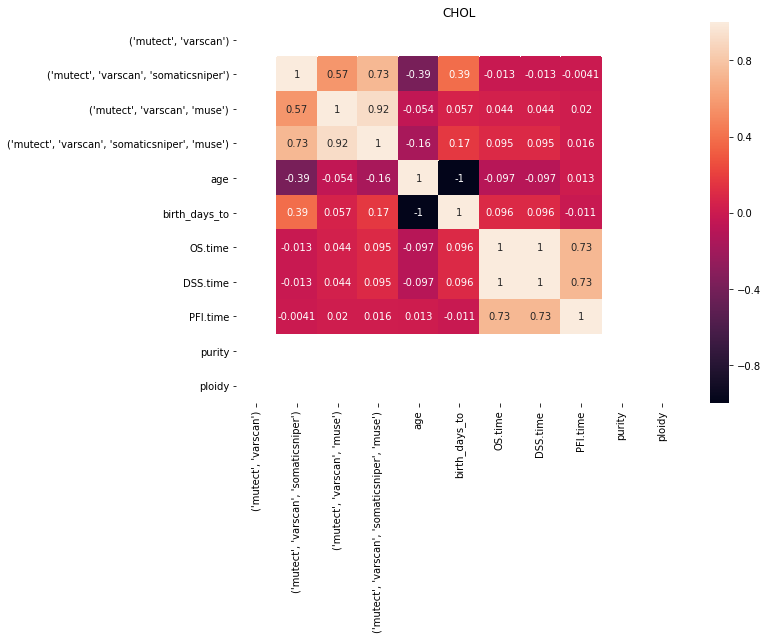

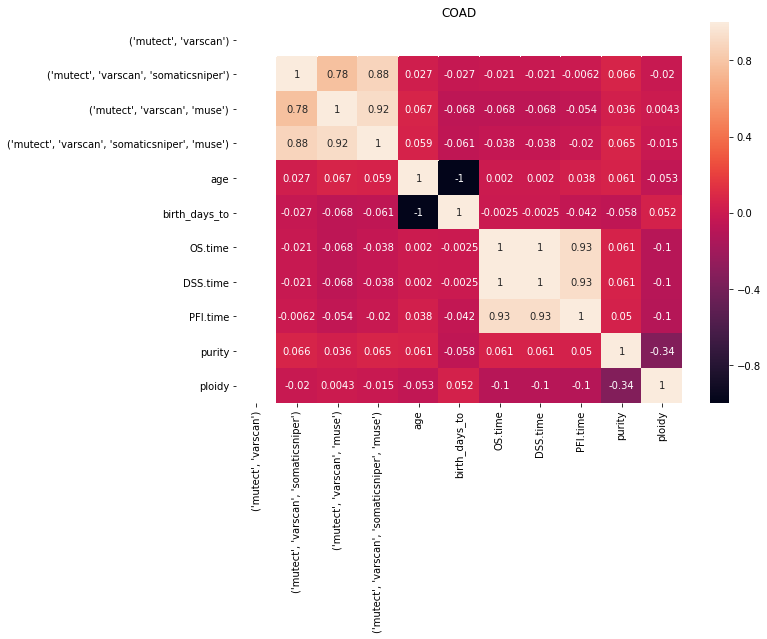

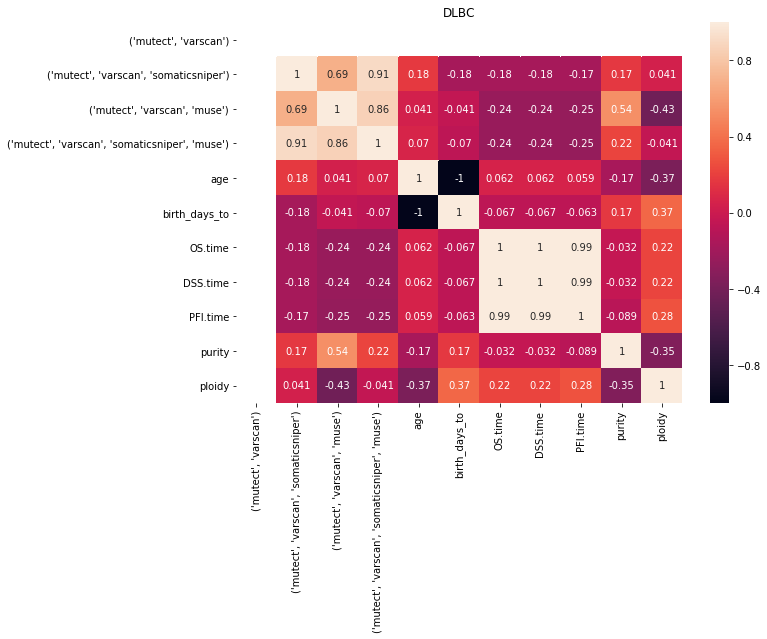

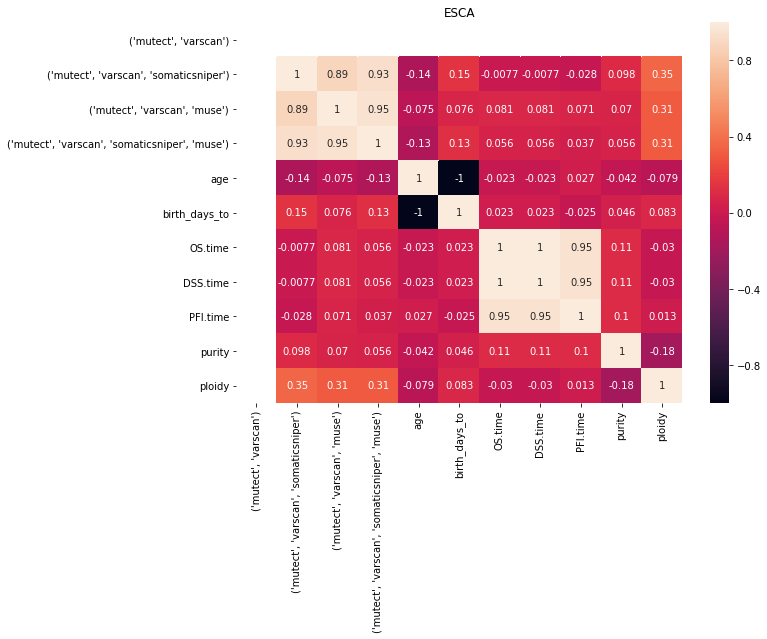

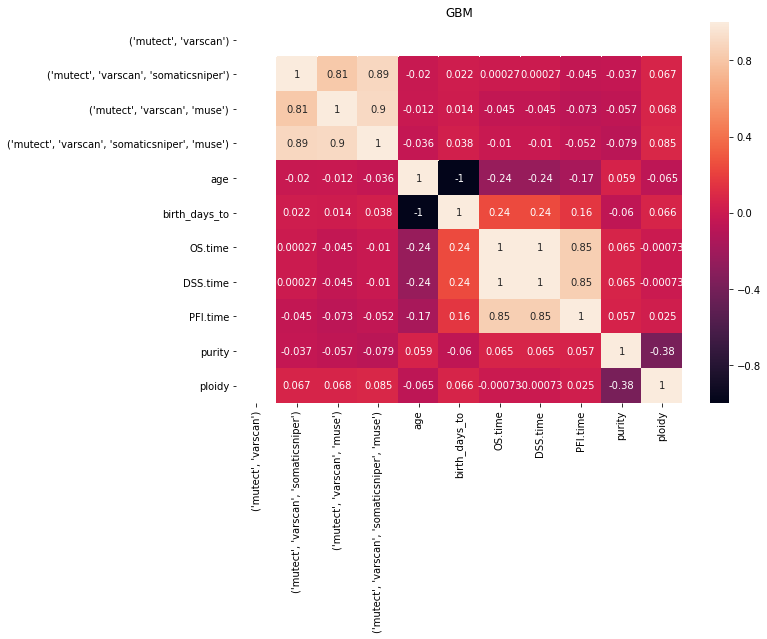

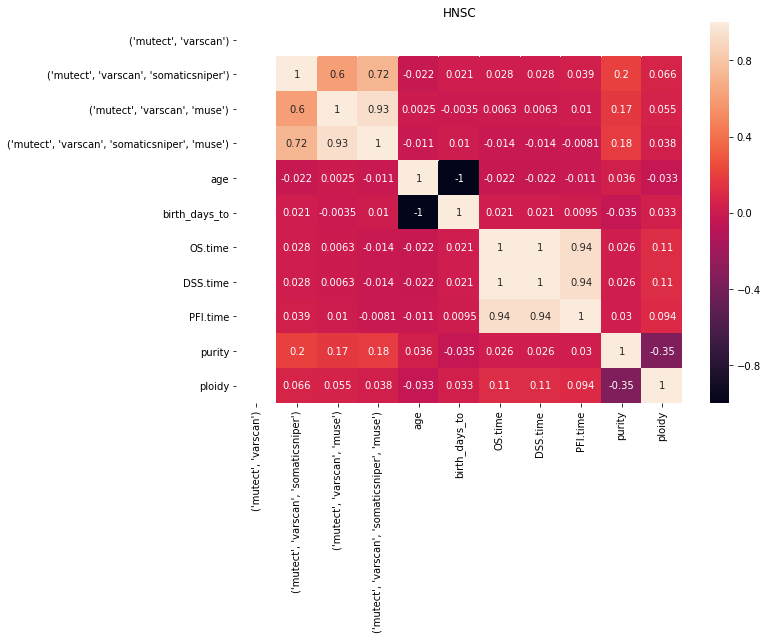

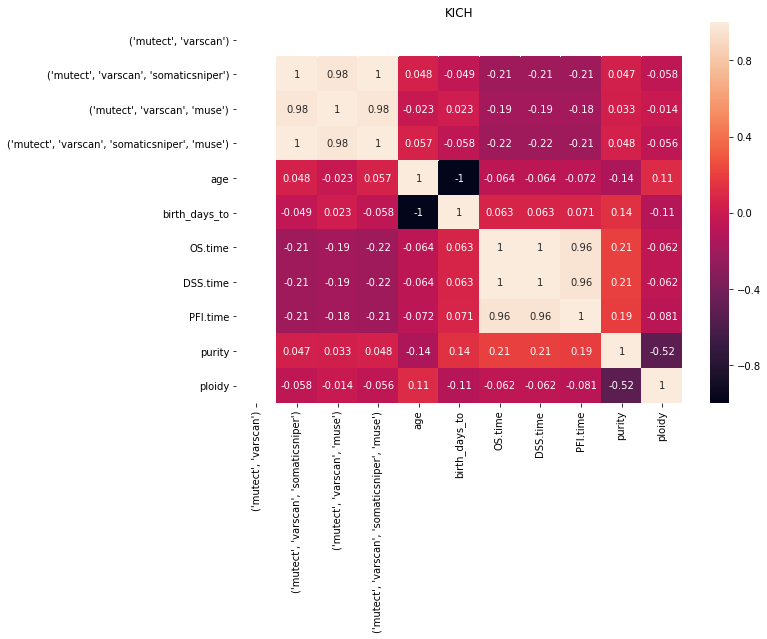

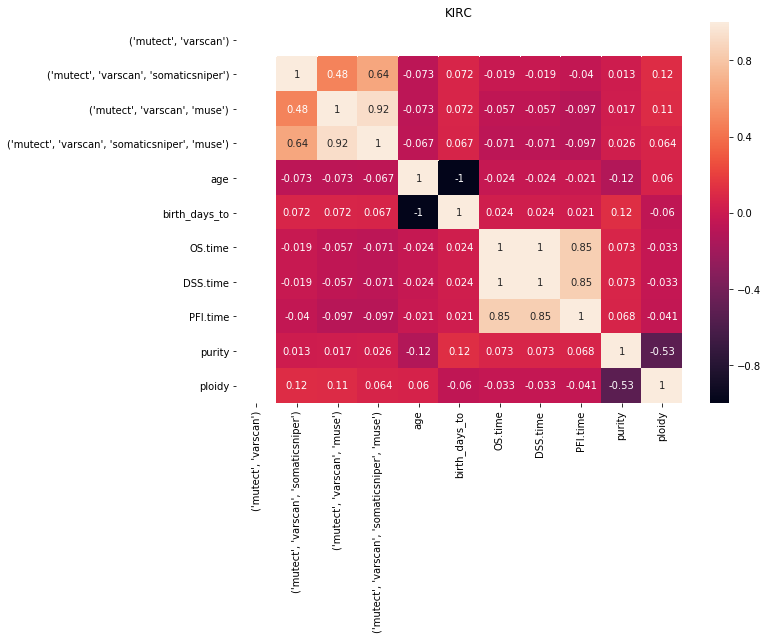

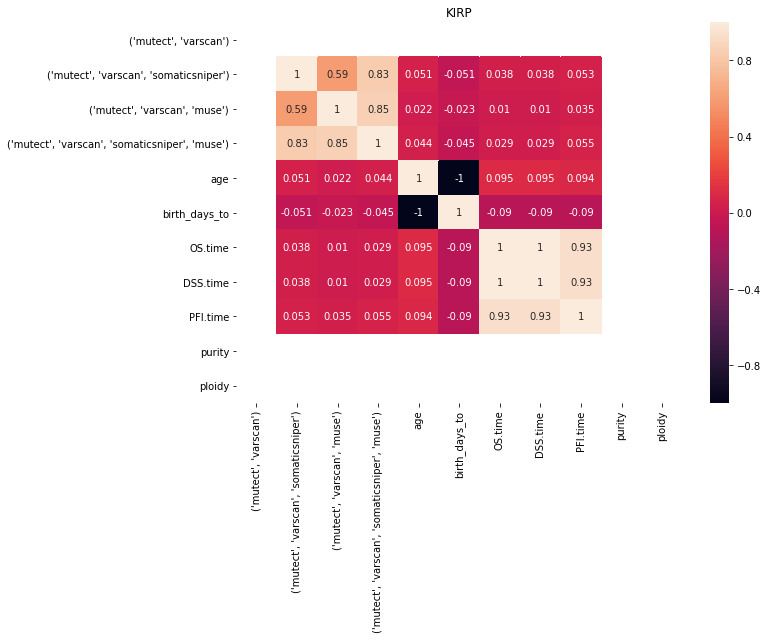

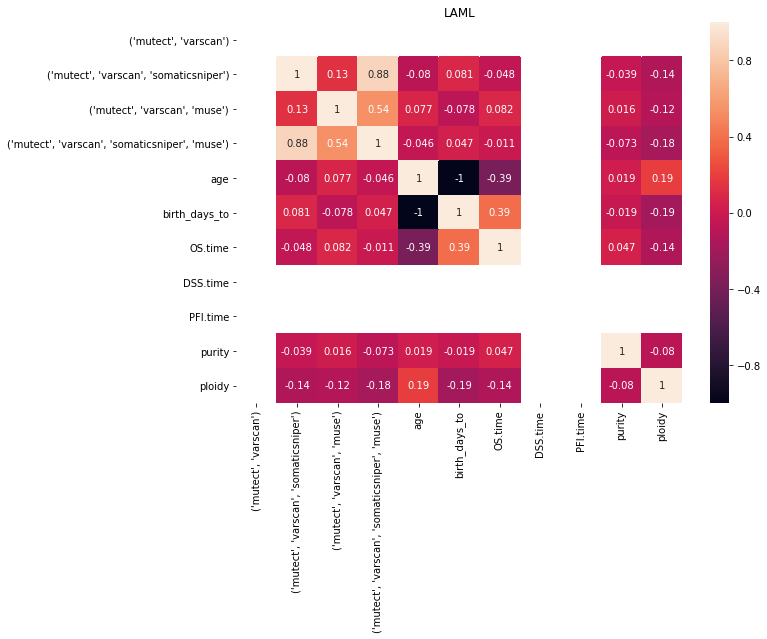

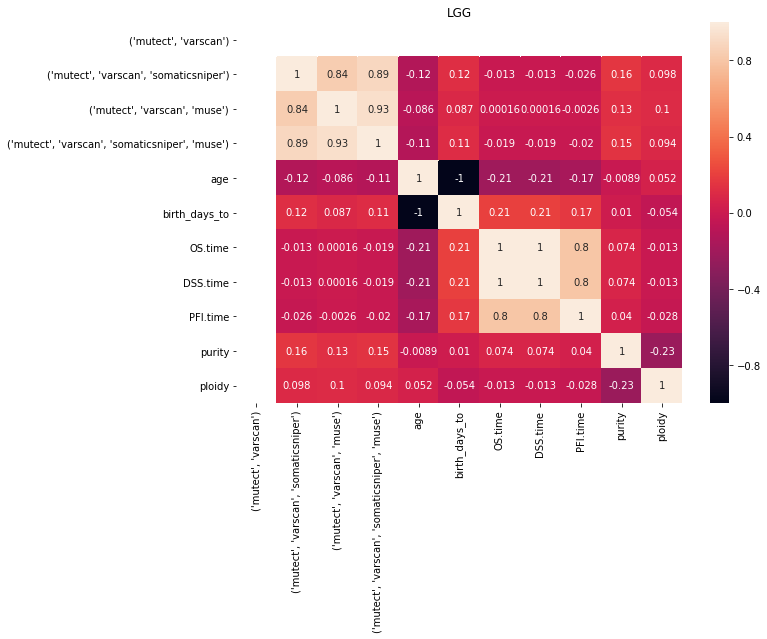

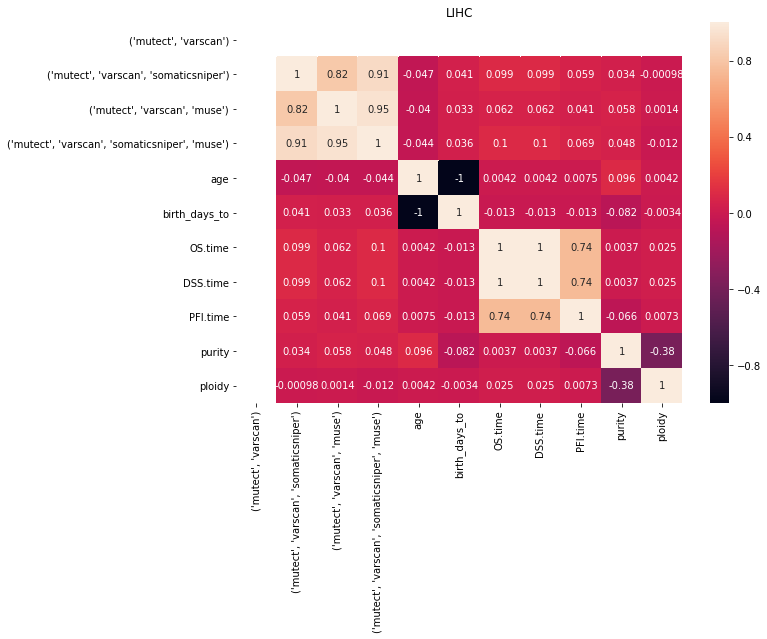

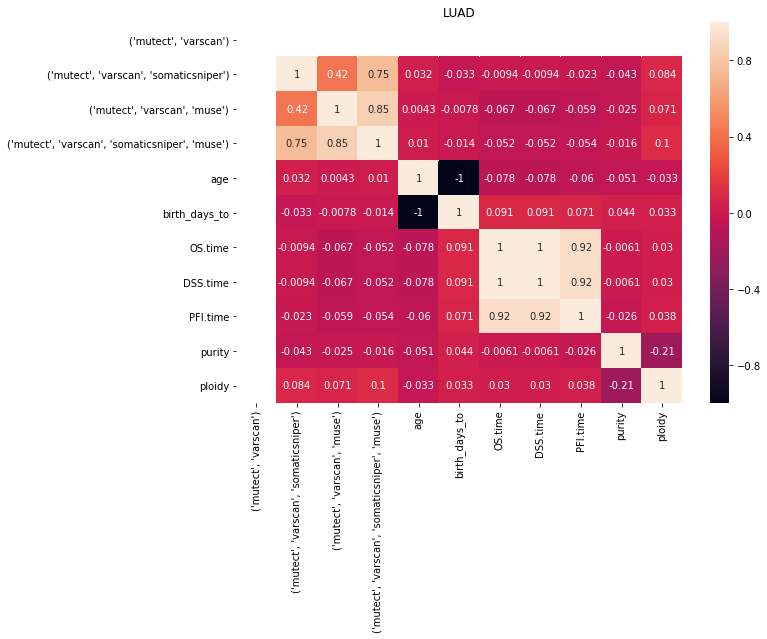

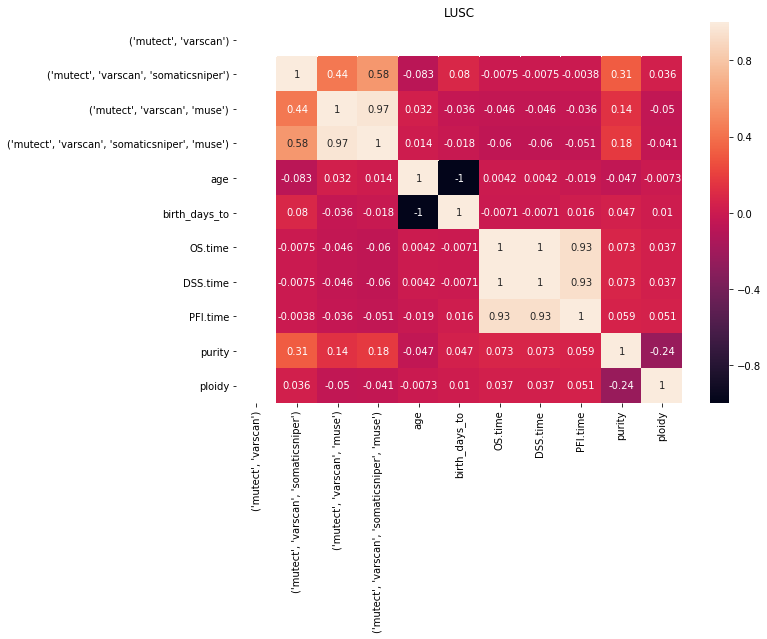

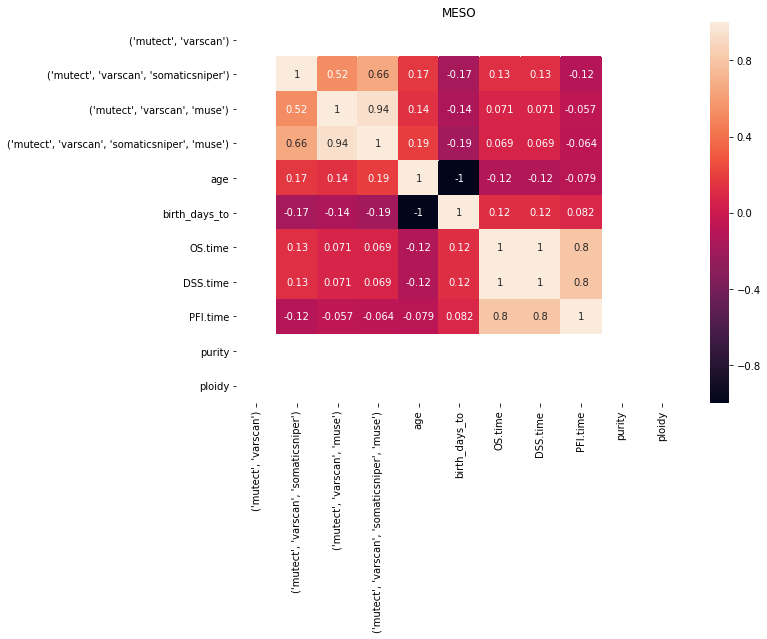

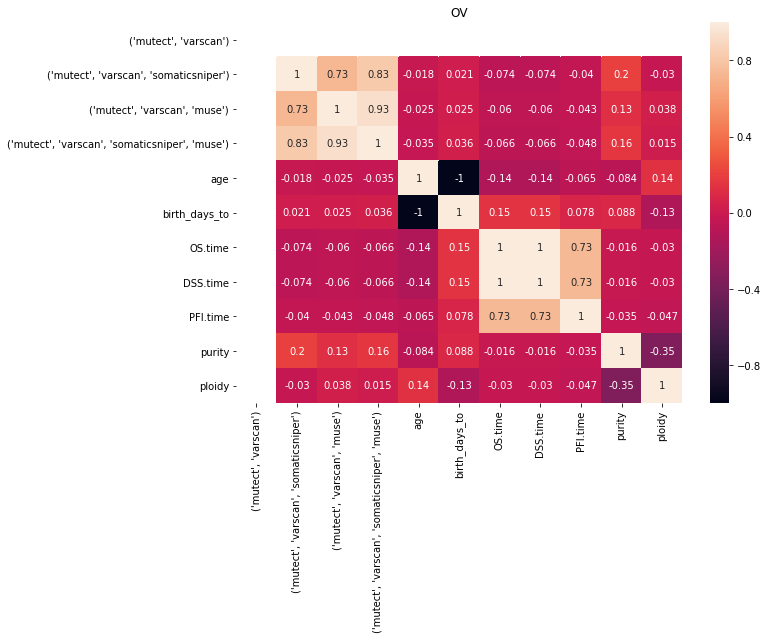

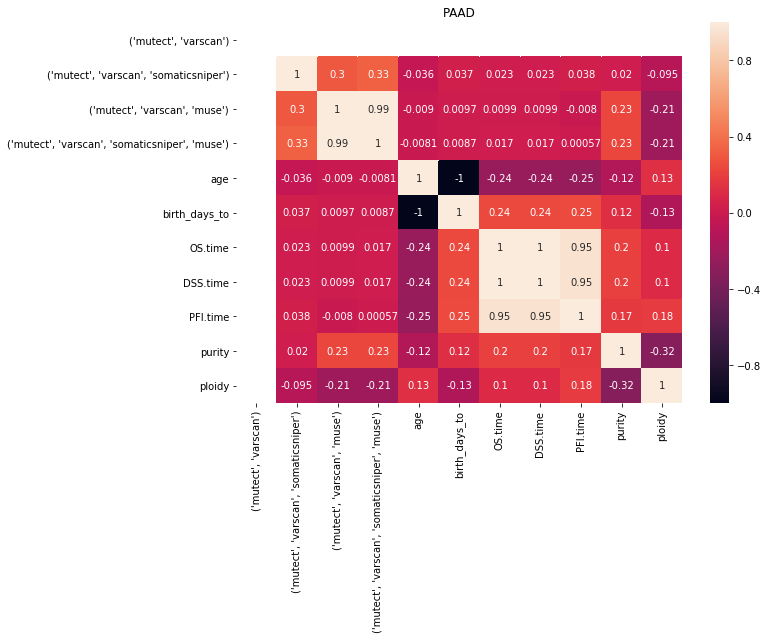

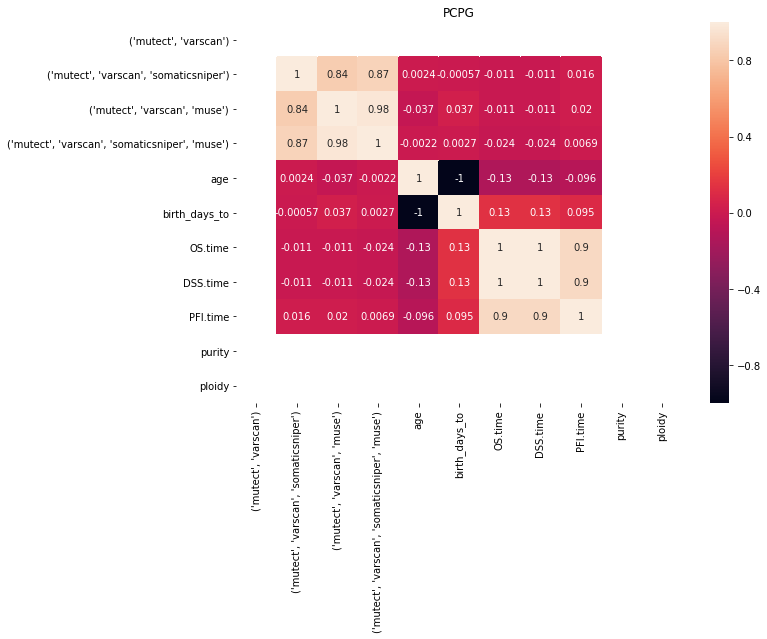

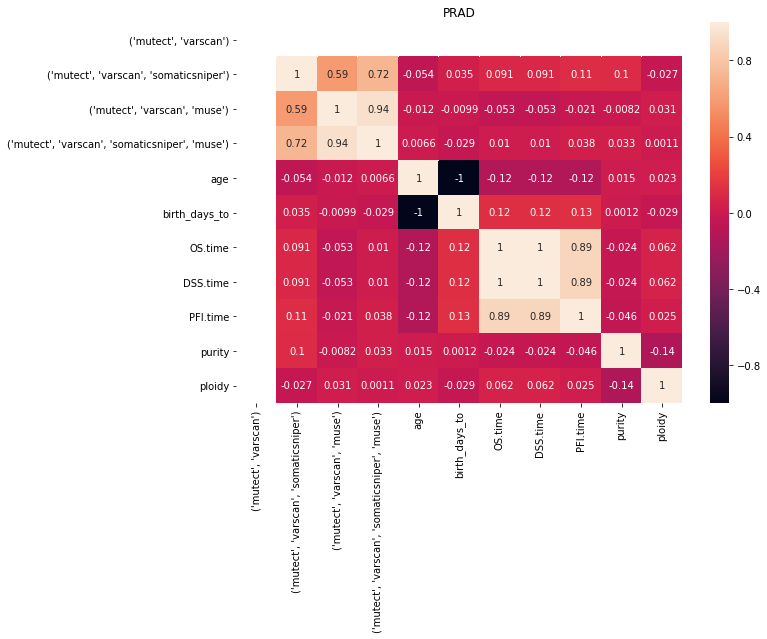

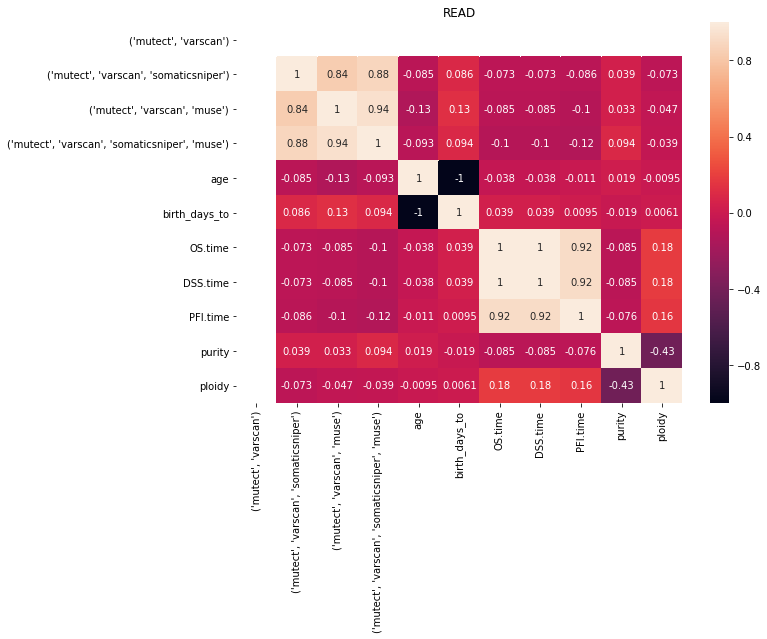

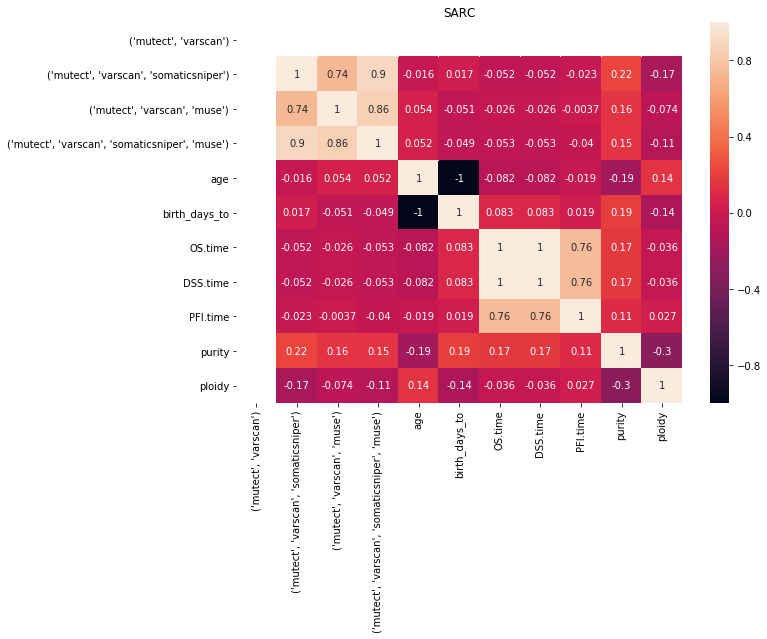

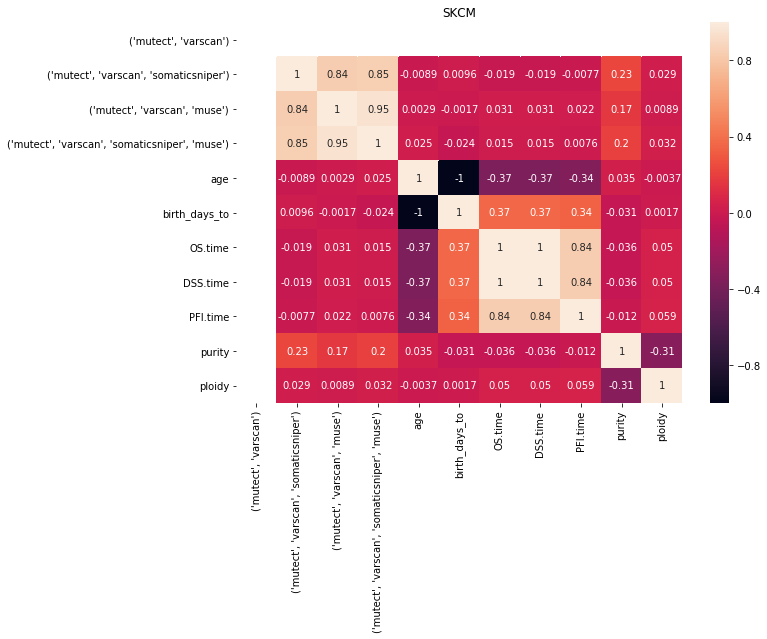

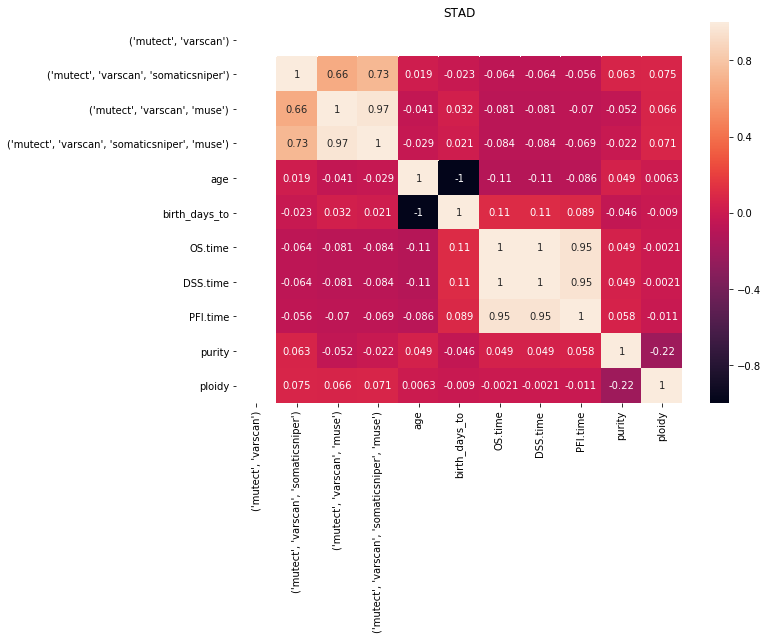

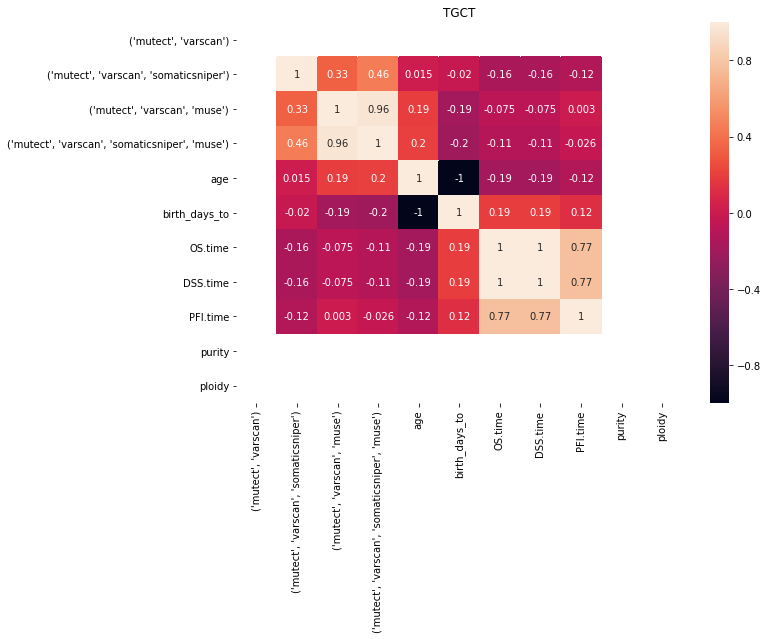

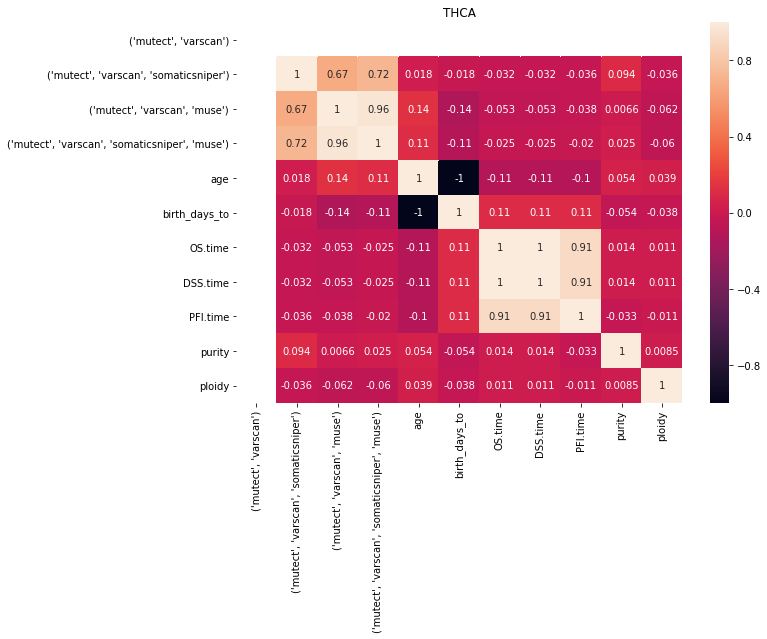

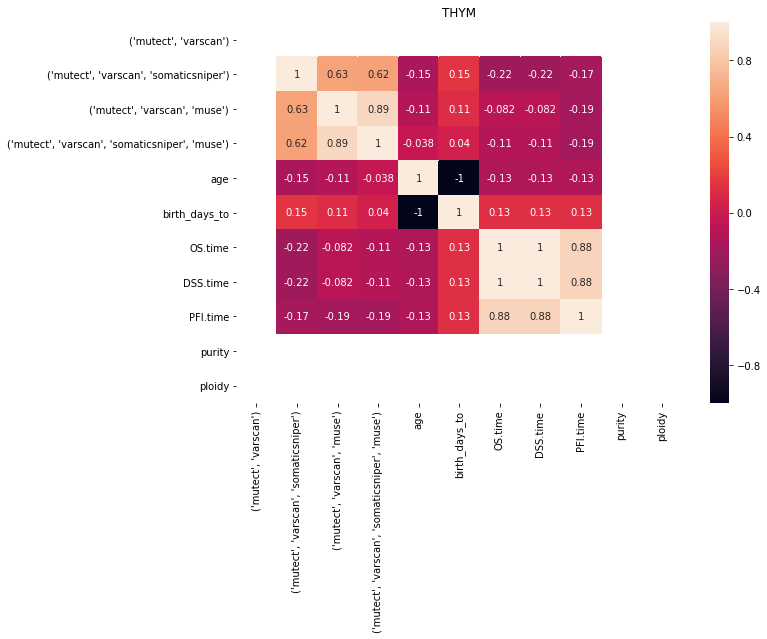

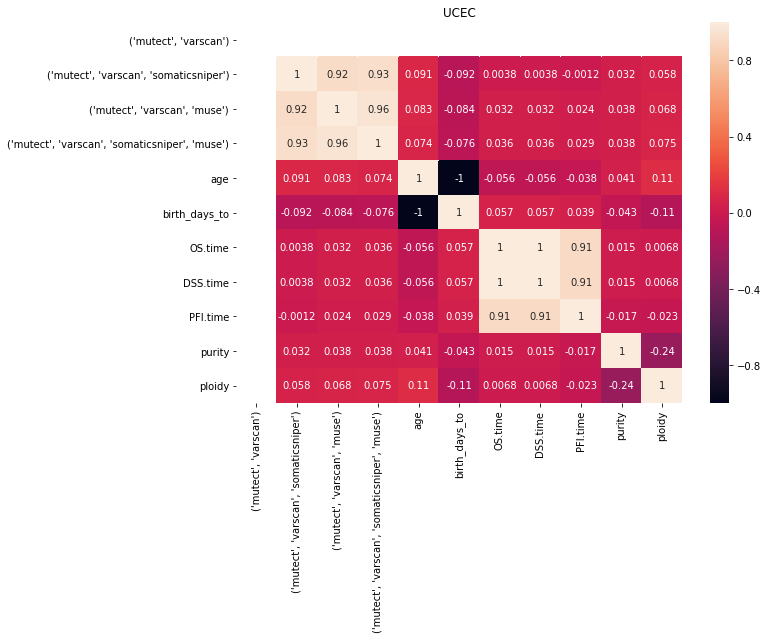

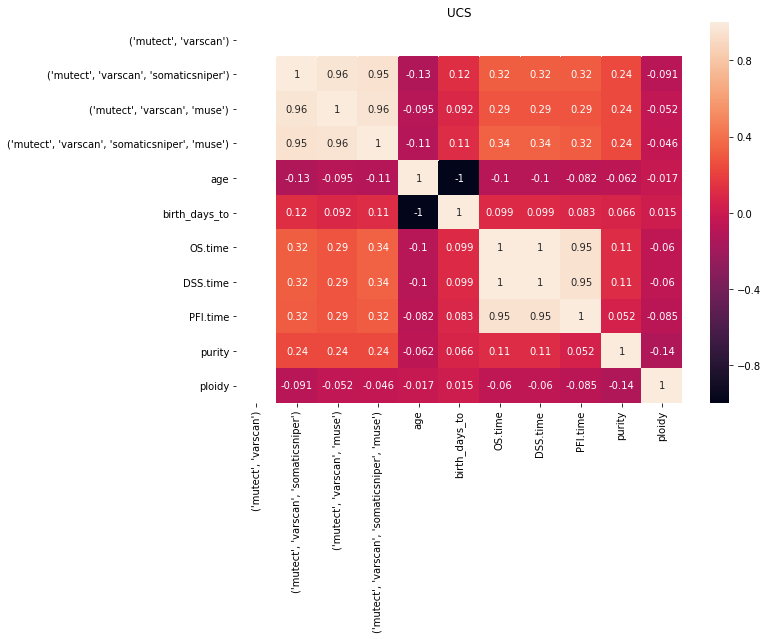

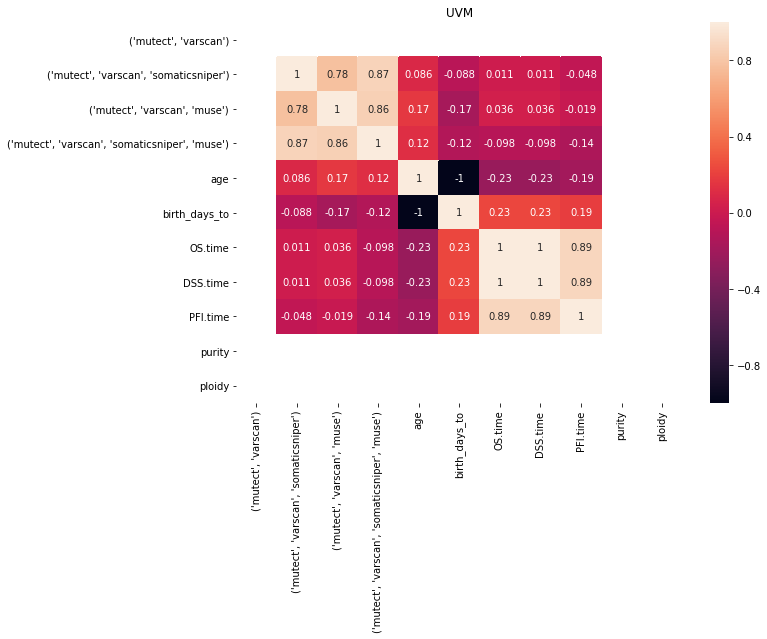

In [480]:
import seaborn as sns
dataframes = {}
# summary statistics, variant callers that always catch a specific variant, map to Bailey 
for cancer in possible_cancers:
    
    os.chdir(original)
    os.chdir(cancer)
    mafs = os.listdir()

    maf_fps = {}
    for caller in possible_callers:
        for maf in mafs:
            if caller in maf: # str in the filepath
                maf_fps[caller] = maf

    all_variants = {}
    new_keys = {}
    new_keys_index = {}
    for caller in maf_fps:
        newkey = []
        all_variants[caller] = parse_maf(maf_fps[caller])
        for key in all_variants[caller].keys():
            newkey.append(key[:12])
        new_keys[caller] = newkey

    arg = []
    for i in range(len(possible_callers)):
        arg.append(all_variants[possible_callers[i]])
    
    oldpatients = set(list(arg[0].keys()))
    for i in range(len(arg)):
        oldpatients = oldpatients & set(list(arg[i].keys()))

    oldpatients = list(oldpatients)

    patients = []
    for patient in oldpatients:
        patients.append(patient[:12])
        
    new_keys_index = dict([(patient, 0) for patient in patients])

    delete = []
    for patient in patients:
        if patient in list(tcga['bcr_patient_barcode']):
            index = tcga.loc[tcga['bcr_patient_barcode'] == patient].index[0]
            new_keys_index[patient] = index
        else:
            delete.append(patient)
            #print(patient)
            #patients.remove(patient)
            del new_keys_index[patient]
    
    for patient in delete:
        patients.remove(patient)
        
    os.chdir(original)

    sets = []
    if len(callers) >= 1:
        sets.append(list(callers))
    ad = my_combs_all(additional_callers, len(additional_callers))

    for n in range(len(ad)):
        sets.append(callers+list(ad[n]))

    for i in range(len(sets)):
        sets[i] = tuple(sets[i])

    df = pd.DataFrame(np.nan, index=patients, columns = sets)

    for n in range(len(patients)):
    
        individual_df = pd.DataFrame(0, index=keys, columns=[cancer,])
        data = dict([(key, []) for key in keys])
        sets = []
        for j in range(len(arg)):
            sets.append(arg[j][oldpatients[n]])
        
        inters = intersections(sets)
    
        for i in range(len(inters)):
            data[keys[i]].extend(list(inters[i]))
        
        individual_df.loc[:,cancer] = how_many_tumor_cgc(data, cgc, filt, impacts, keys)
    
        t = table(callers, additional_callers, cancer, 2, impacts, filt, keys, bcp = individual_df, individual = True, tab = False)        
        for k in range(len(t.index)):
            df.at[patients[n], t.index[k]] = t['real % diff'][k]
    age = []
    birth_days_to = []
    os_time = []
    dss_time = []
    pfi_time = []
    for patient in patients:
        age.append(tcga['age_at_initial_pathologic_diagnosis'][new_keys_index[patient]])
        birth_days_to.append(tcga['birth_days_to'][new_keys_index[patient]])
        os_time.append(tcga['OS.time'][new_keys_index[patient]])
        dss_time.append(tcga['DSS.time'][new_keys_index[patient]])
        pfi_time.append(tcga['PFI.time'][new_keys_index[patient]])
    df['age'] = age
    df['birth_days_to'] = birth_days_to
    df['OS.time'] = os_time
    df['DSS.time'] = dss_time
    df['PFI.time'] = pfi_time
    purity = []
    ploidy = []
    for patient in df.index:
        if patient in list(ascat['Sample']):
            index = ascat.loc[ascat['Sample'] == patient].index[0]
            purity.append(ascat.loc[index]['Aberrant_Cell_Fraction(Purity)'])
            ploidy.append(ascat.loc[index]['Ploidy'])
        else:
            purity.append(np.nan)
            ploidy.append(np.nan)
    df['purity'] = purity
    df['ploidy'] = ploidy
    dataframes[cancer] = df
    corr = df.corr()
    corr.style.background_gradient(cmap='coolwarm')
    pyplot.figure(figsize = (10,7))
    pyplot.title(cancer)
    ax = sns.heatmap(corr, annot=True)
    pyplot.show()
                                         
                                    

LUSC
-0.06001893336387206


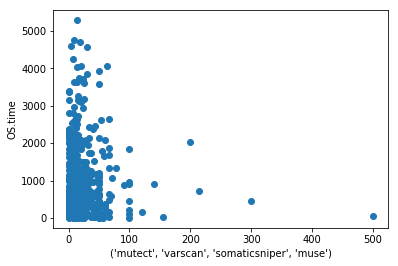

In [560]:
# criteria for investigating scatter plots: correlation above .10
def scatter(cancer, x, y):
    print(cancer)
    scatter_df = dataframes[cancer]
    pyplot.scatter(scatter_df[x], scatter_df[y])
    pyplot.xlabel(x)
    pyplot.ylabel(y)
    print(scatter_df.corr()[y][x])

scatter('LUSC', ('mutect', 'varscan', 'somaticsniper', 'muse'), 'OS.time')

In [ ]:
possible_cancers = ('ACC', 'BLCA','BRCA','CESC','CHOL','COAD','DLBC','ESCA','GBM','HNSC', 
                    'KICH','KIRC','KIRP','LAML','LGG','LIHC','LUAD','LUSC','MESO', 'OV','PAAD',
                    'PCPG','PRAD','READ','SARC','SKCM','STAD','TGCT','THCA','THYM','UCEC','UCS','UVM')